Data Explanation:
1. **bill / fr_bill / uk_bill**: 
  *   original data

2. **bill_clean / fr_bill_clean / uk_bill_clean**: cleaned data. 
  *   An extra column 'date' is added if there is no in the original one.
  *   The 'date' (date on chart) are adjusted so that they are all Fridays in every week.
  *   An extra column 'isNew' is added if there is no in the original one.
  *   Extra time information about chart (year,week) are dropped. The only resource to know the timing about chart is date. Note that the 'week' data after cleaning means the num of weeks in charts.

3. **yr_range**:
  *   The common dates to all three rankings.
  *   Used later to align data (same start and end date).
  *   All data after date alignment have suffix '_cut'. E.g. 'bill_clean' is not time aligned, and 'bill_clean_cut' is time aligned.
  
4. **bill_s_merge / fr_bill_s_merge / uk_bill_s_merge**:
  *  Merged data using 'x_clean' data and spotify data.

5. **bill_s_merge_cut / fr_bill_s_merge_cut / uk_bill_s_merge_cut**:
  *  As stated in 3.

6. **bill_s_ms_merge / fr_bill_s_ms_merge / uk_bill_s_ms_merge**:
  *  Merged data using 'x_s_merge' data and Million Song dataset.

7. **bill_s_ms_merge_cut / fr_bill_s_ms_merge_cut / uk_bill_s_ms_merge_cut**:
  *  As stated in 3.

In [1]:
running_in_colab = 'google.colab' in str(get_ipython())

if running_in_colab:
    !pip install unidecode
    
print("Running on Google CoLab" if running_in_colab else "Running on ipython notebook")

Running on ipython notebook


In [2]:
from datetime import datetime,timedelta,date
import functools as ft
import itertools as it
from pathlib import Path
import string
import sys

import h5py
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from matplotlib import dates
from matplotlib.dates import DateFormatter
import pandas as pd 
import seaborn as sns 
from sklearn.decomposition import PCA
import statsmodels.api as sm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from unidecode import unidecode


rng = default_rng()
#from fuzzymatcher import fuzzy_left_join



from sklearn.preprocessing import LabelEncoder

In [3]:
#Directory structure

if running_in_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    base_dir = Path("/content/drive/My Drive/ECE 143 Project")
    data_dir = base_dir / "datasets"
else:
    base_dir = Path("..")
    data_dir = base_dir / "data"

output_dir = base_dir / "outputs"
if not output_dir.exists():
    output_dir.mkdir()
    
if running_in_colab:
    !git clone https://github.com/nephanth/ECE143.git
    sys.path.append("./ECE143")
else:
    sys.path.append("..")

In [4]:
import utils

# Data Cleanup

In [5]:
from utils.cleaning import clean, decode, spotify_clean_up

In [6]:
bill = pd.read_csv(data_dir / 'billboard_data.csv')
fr_bill = pd.read_csv(data_dir / 'french_charts.csv', index_col=0,
                        dtype= {"evol":"category", "artist":"string", "title":"string"})
uk_bill = pd.read_csv(data_dir / 'UK_charts.csv', index_col=0,
                          dtype={"last-week":"category", "title":"string", 
                                 "artist":"string", "label-cat":"string",},
                        parse_dates=True)

In [7]:
bill.head()

,date,weeks,title,artist,rank,peakpos,lastpos,isnew
0,2022-02-19,7,We Don't Talk About Bruno,"Carolina Gaitan, Mauro Castillo, Adassa, Rhenz...",1,1,1,False
1,2022-02-19,1,Do We Have A Problem?,Nicki Minaj X Lil Baby,2,2,0,True
2,2022-02-19,18,Easy On Me,Adele,3,1,2,False
3,2022-02-19,56,Heat Waves,Glass Animals,4,3,3,False
4,2022-02-19,31,Stay,The Kid LAROI & Justin Bieber,5,1,4,False


In [8]:
fr_bill.head()

,position,evol,artist,title,year,week
0,1,=,Peter et Sloane,"Besoin de rien, envie de toi",1984,47
1,2,=,Stevie Wonder,I Just Called To Say I Love You,1984,47
2,3,+1,Cookie Dingler,Femme libérée,1984,47
3,4,Entrée,Frédéric François,Mon coeur te dit je t'aime,1984,47
4,5,=,Ray Parker Jr.,Ghostbusters,1984,47


In [9]:
uk_bill.head()

,position,last-week,title,artist,label-cat,peak position,weeks of charts,year,week,date
0,1,New,HERE IN MY HEART,AL MARTINO,CAPITOL,1,1,1952,46,1952-11-14
1,1,New,HERE IN MY HEART,AL MARTINO,CAPITOL,1,1,1952,46,1952-11-14
2,1,New,HERE IN MY HEART,AL MARTINO,CAPITOL,1,1,1952,46,1952-11-14
3,2,New,YOU BELONG TO ME,JO STAFFORD,COLUMBIA,2,1,1952,46,1952-11-14
4,3,New,SOMEWHERE ALONG THE WAY,NAT 'KING' COLE,CAPITOL,3,1,1952,46,1952-11-14


In [10]:
clean_up_col = ['title','artist']
bill_clean = clean(bill,clean_up_col)
bill_clean['date'] = pd.to_datetime(bill_clean['date'], infer_datetime_format=True)
bill_clean['date'] = bill_clean['date']-timedelta(1)  # original in Saturday, all transform to friday
# bill_clean['date'].dt.strftime('%Y-%m-%d')
# bill_clean.drop(['date'],axis=1, inplace=True)
bill_clean

,date,weeks,title,artist,rank,peakpos,lastpos,isnew
0,2022-02-18,7,we dont talk about bruno,carolina gaitan mauro castillo adassa rhenzy f...,1,1,1,False
1,2022-02-18,1,do we have a problem,nicki minaj x lil baby,2,2,0,True
2,2022-02-18,18,easy on me,adele,3,1,2,False
3,2022-02-18,56,heat waves,glass animals,4,3,3,False
4,2022-02-18,31,stay,the kid laroi justin bieber,5,1,4,False
...,...,...,...,...,...,...,...,...
234694,1977-03-04,2,theme from rocky gonna fly now,rhythm heritage,95,96,98,False
234695,1977-03-04,1,try it on,exile,96,97,0,True
234696,1977-03-04,9,fancy dancer,commodores,97,39,56,False
234697,1977-03-04,1,it aint easy comin down,charlene,98,99,0,True


In [11]:
fr_bill_clean = fr_bill.drop_duplicates().dropna()
# fr_bill_clean['evol'].replace('=',0)
# fr_bill_clean['evol'].rename_categories([])
fr_bill_clean = clean(fr_bill_clean, ["title", "artist","evol"])

#trick to change week + year into date
fr_bill_clean['date'] = fr_bill_clean.year * 1000 + fr_bill_clean.week * 10 + 5
fr_bill_clean['date'] = pd.to_datetime(fr_bill_clean['date'], format='%Y%W%w')

fr_bill_clean['isnew'] = fr_bill_clean['evol']=='entree'
fr_bill_clean.drop(['week','year'],axis=1,inplace=True)
fr_bill_clean

,position,evol,artist,title,date,isnew
0,1,,peter et sloane,besoin de rien envie de toi,1984-11-23,False
1,2,,stevie wonder,i just called to say i love you,1984-11-23,False
2,3,1,cookie dingler,femme liberee,1984-11-23,False
3,4,entree,frederic francois,mon coeur te dit je taime,1984-11-23,True
4,5,,ray parker jr,ghostbusters,1984-11-23,False
...,...,...,...,...,...,...
93045,46,3,the weeknd,in your eyes,2020-12-25,False
93046,47,13,johnny hallyday,deux sortes dhommes nashville blues live,2020-12-25,False
93047,48,entree,andy muschietti,ca,2020-12-25,True
93048,49,48,mylene farmer,lame dans leau,2020-12-25,False


We can observe johnny hallyday was still making the charts in december 2020, three years after his death. and that is pretty impressive

In [12]:
uk_bill.date = pd.to_datetime(uk_bill.date)
uk_bill_clean = clean(uk_bill, ["title", "artist", "label-cat"])
uk_bill_clean = uk_bill_clean.drop_duplicates()
uk_bill_clean.drop(['year','week'], axis=1, inplace=True)
uk_bill_clean.rename({'weeks of charts': 'week'}, axis=1, inplace=True)
uk_bill_clean['isnew'] = uk_bill_clean['last-week']=='New'    # note: re-enter song is not labled as isNew   
uk_bill_clean

/tmp/ipykernel_2009437/1425780252.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uk_bill_clean.drop(['year','week'], axis=1, inplace=True)
/tmp/ipykernel_2009437/1425780252.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uk_bill_clean.rename({'weeks of charts': 'week'}, axis=1, inplace=True)
/tmp/ipykernel_2009437/1425780252.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

,position,last-week,title,artist,label-cat,peak position,week,date,isnew
0,1,New,here in my heart,al martino,capitol,1,1,1952-11-14,True
3,2,New,you belong to me,jo stafford,columbia,2,1,1952-11-14,True
4,3,New,somewhere along the way,nat king cole,capitol,3,1,1952-11-14,True
5,4,New,the isle of innisfree,bing crosby,brunswick,4,1,1952-11-14,True
6,5,New,feet up pat him on the popo,guy mitchell,columbia,5,1,1952-11-14,True
...,...,...,...,...,...,...,...,...,...
274044,96,Re,little things,abba,polar,61,3,2021-12-31,False
274045,97,Re,i want to come home for christmas,summer walker,interscope,94,2,2021-12-31,False
274046,98,New,jingle bell rock,alessia cara,virgin,98,1,2021-12-31,True
274047,99,New,kiss me its christmas,leona lewis ft neyo,sony music cg,99,1,2021-12-31,True


In [13]:
yr_range = pd.merge(bill_clean['date'], fr_bill_clean['date'], how='inner')['date'].drop_duplicates().reset_index(drop=True)
yr_range = pd.merge(yr_range, uk_bill_clean['date'], how='inner')['date'].drop_duplicates().reset_index(drop=True)
yr_range

0      2020-12-25
1      2020-12-18
2      2020-12-11
3      2020-12-04
4      2020-11-27
          ...    
1853   1984-12-21
1854   1984-12-14
1855   1984-12-07
1856   1984-11-30
1857   1984-11-23
Name: date, Length: 1858, dtype: datetime64[ns]

In [14]:
bill_clean_cut = pd.merge(bill_clean, yr_range, how='inner')
bill_clean_cut

,date,weeks,title,artist,rank,peakpos,lastpos,isnew
0,2020-12-25,1,willow,taylor swift,1,1,0,True
1,2020-12-25,42,all i want for christmas is you,mariah carey,2,1,1,False
2,2020-12-25,37,rockin around the christmas tree,brenda lee,3,2,3,False
3,2020-12-25,34,jingle bell rock,bobby helms,4,3,5,False
4,2020-12-25,19,mood,24kgoldn featuring iann dior,5,1,2,False
...,...,...,...,...,...,...,...,...
185795,1984-11-23,12,strung out,steve perry,96,40,75,False
185796,1984-11-23,15,are we ourselves,the fixx,97,15,90,False
185797,1984-11-23,7,after all,al jarreau,98,69,95,False
185798,1984-11-23,12,body rock,maria vidal,99,48,84,False


In [15]:
fr_bill_clean_cut = pd.merge(fr_bill_clean, yr_range, how='inner')
fr_bill_clean_cut
# rank_count = fr_bill_clean_cut.groupby(['title'])['position'].count()
# rank_count
# for i in range(93050):
#   fr_bill_clean['title'][i] 
# bill_clean.groupby(['title'])["rank"].count().sort_values(ascending=False).head(10)

,position,evol,artist,title,date,isnew
0,1,,peter et sloane,besoin de rien envie de toi,1984-11-23,False
1,2,,stevie wonder,i just called to say i love you,1984-11-23,False
2,3,1,cookie dingler,femme liberee,1984-11-23,False
3,4,entree,frederic francois,mon coeur te dit je taime,1984-11-23,True
4,5,,ray parker jr,ghostbusters,1984-11-23,False
...,...,...,...,...,...,...
92794,46,3,the weeknd,in your eyes,2020-12-25,False
92795,47,13,johnny hallyday,deux sortes dhommes nashville blues live,2020-12-25,False
92796,48,entree,andy muschietti,ca,2020-12-25,True
92797,49,48,mylene farmer,lame dans leau,2020-12-25,False


In [16]:
uk_bill_clean_cut = pd.merge(uk_bill_clean, yr_range, how='inner')
uk_bill_clean_cut

,position,last-week,title,artist,label-cat,peak position,week,date,isnew
0,1,1,i feel for you,chaka khan,warner brothers,1,6,1984-11-23,False
1,2,3,i should have known better,jim diamond,am,2,5,1984-11-23,False
2,3,2,the wild boys,duran duran,emi,2,4,1984-11-23,False
3,4,5,never ending story,limahl,emi,4,7,1984-11-23,False
4,5,17,the riddle,nik kershaw,mca,5,2,1984-11-23,False
...,...,...,...,...,...,...,...,...,...
182122,96,Re,mistletoe and wine,cliff richard,emi,1,15,2020-12-25,False
182123,97,62,plugged in freestyle,fumez the engineera92offica,fumez the engineer,39,7,2020-12-25,False
182124,98,Re,santa baby,eartha kitt,rca,55,11,2020-12-25,False
182125,99,63,wonder,shawn mendes,emi,20,12,2020-12-25,False


Reformate date to same time range from 1984-11-23 to 2020-12-25. Remember to align rank in cross country analysis (remove extra ranking from 51 to 100)




# 1. Three Rank Analysis

In [29]:
from utils.display import top10
#%load_ext autoreload
%autoreload 2

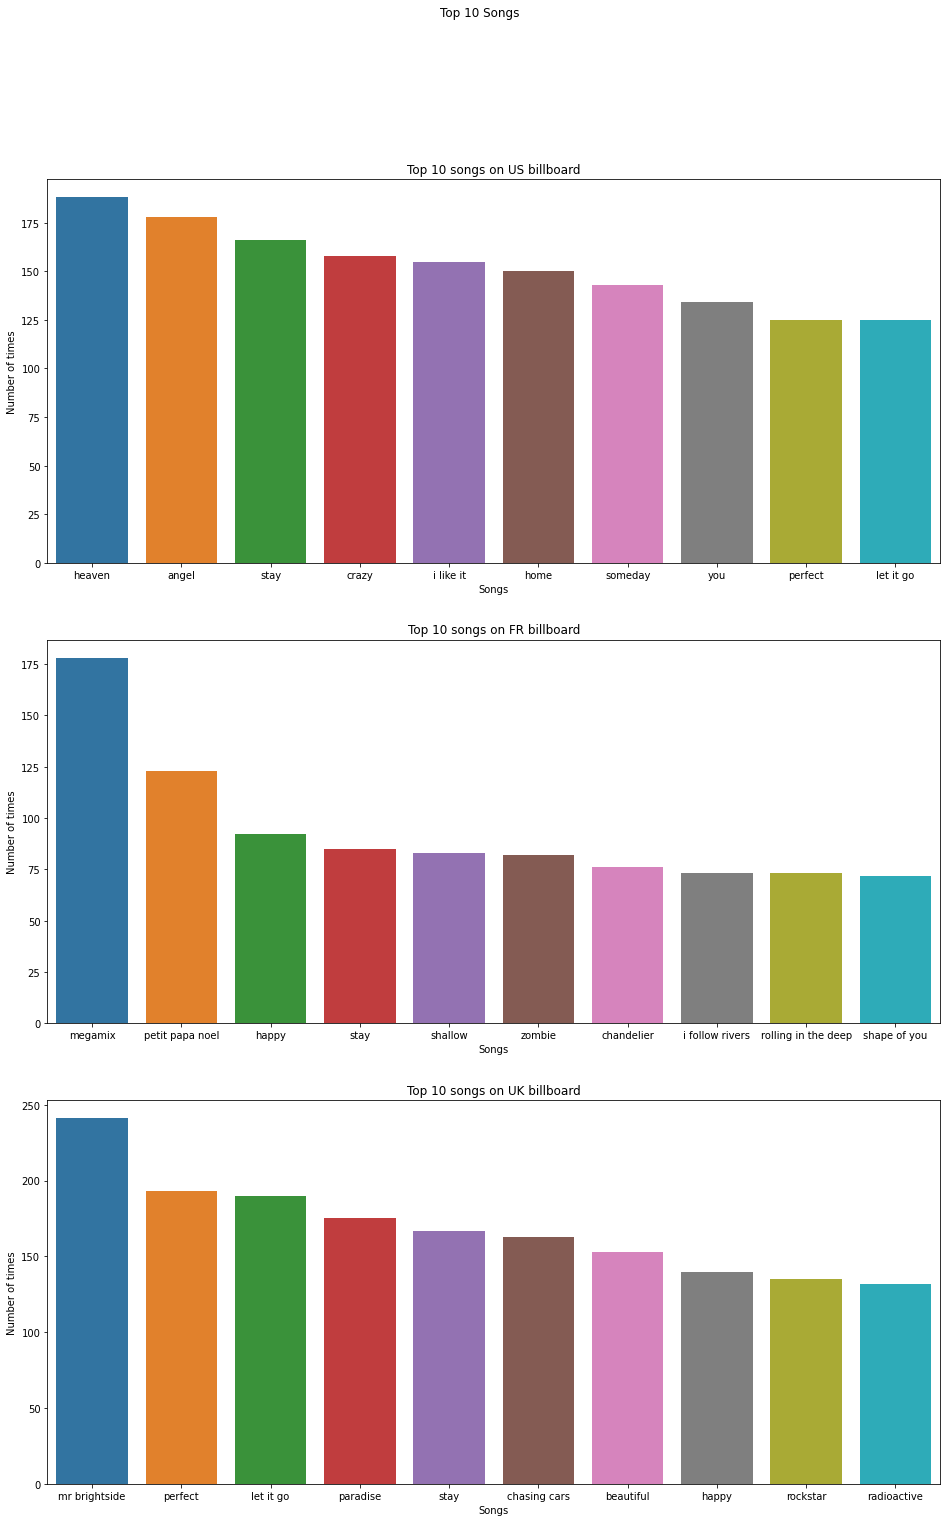

In [28]:
#top 10 songs appear on the billboard 
countries = ("US", "FR", "UK")
billboards = (bill_clean_cut, fr_bill_clean_cut, uk_bill_clean_cut)
_, axes = plt.subplots(3, figsize = (16, 24))
for ax, chart_i, rank, name in zip(axes, billboards,
                 ("rank", "position", "position"),
                 countries
                  ):
    top10(chart_i, by="title", rank=rank, ax=ax)
    ax.set_title(f'Top 10 songs on {name} billboard')
plt.suptitle("Top 10 Songs");

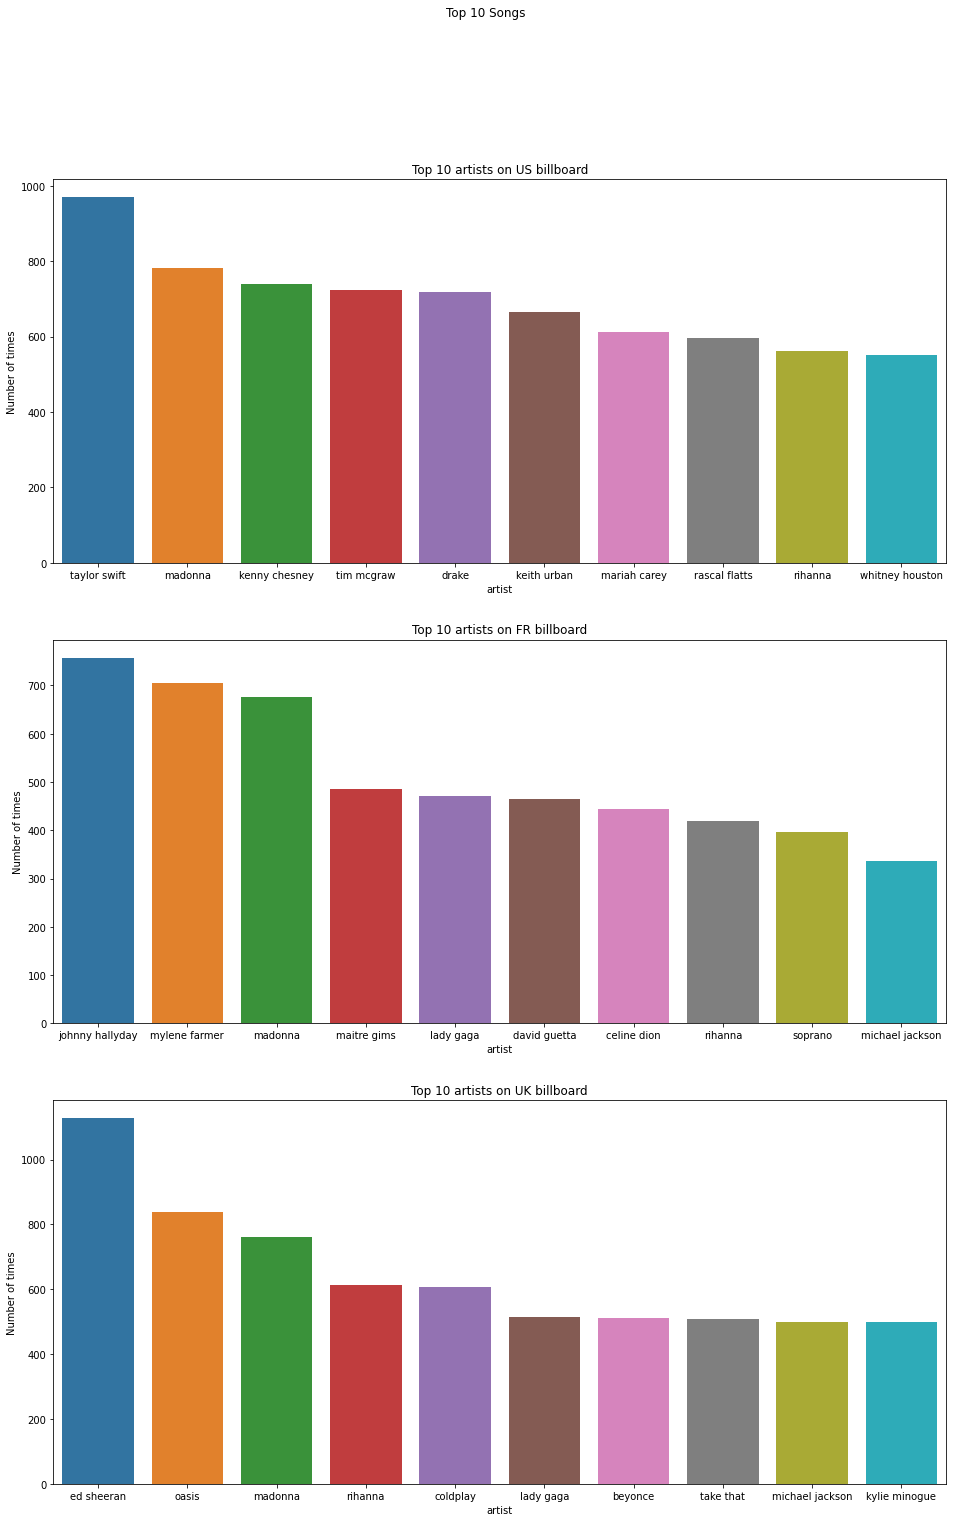

In [31]:
#top 10 songs appear on the billboard 
countries = ("US", "FR", "UK")
billboards = (bill_clean_cut, fr_bill_clean_cut, uk_bill_clean_cut)
_, axes = plt.subplots(3, figsize = (16, 24))
for ax, chart_i, rank, name in zip(axes, billboards,
                 ("rank", "position", "position"),
                 countries
                  ):
    top10(chart_i, by="artist", rank=rank, ax=ax)
    ax.set_title(f'Top 10 artists on {name} billboard')
plt.suptitle("Top 10 Songs");

# 2. Merge Three Ranking Dataset with Song Meta Data (Spotify and Million Song)

In [32]:
#spotify = pd.read_csv('/content/drive/My Drive/ECE 143 Project/datasets/spotify.csv')

spotify = pd.read_csv(data_dir/ 'spotify_new.csv')

In [33]:
spotify.head()

,Unnamed: 0,id,name,popularity,duration_ms,explicit,artists,id_artists,date,danceability,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year
0,0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],2/22/22,0.645,...,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3,2022
1,1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],6/1/22,0.695,...,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1,2022
2,2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],3/21/22,0.434,...,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5,2022
3,3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],3/21/22,0.321,...,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3,2022
4,4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],4/5/05,0.402,...,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4,2005


In [34]:
spotify.dtypes

Unnamed: 0            int64
id                   object
name                 object
popularity            int64
duration_ms           int64
explicit              int64
artists              object
id_artists           object
date                 object
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
year                  int64
dtype: object

In [35]:
clean_up_col = ['name','artists']
spotify_clean = spotify_clean_up(spotify.drop(['Unnamed: 0'],axis=1), clean_up_col)
spotify_clean

,id,name,popularity,duration_ms,explicit,artists,id_artists,date,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year
0,35iwgR4jXetI318WEWsa1Q,carve,6,126903,0,uli,['45tIt06XoI0Iio4LBEVpls'],2/22/22,0.645,0.4450,...,-13.338,1,0.4510,0.674,0.744000,0.1510,0.1270,104.851,3,2022
1,021ht4sdgPcrDgSk7JTbKY,capítulo 216 banquero anarquista,0,98200,0,fernando pessoa,['14jtPCOoNZwquk5wd9DxrY'],6/1/22,0.695,0.2630,...,-22.136,1,0.9570,0.797,0.000000,0.1480,0.6550,102.009,1,2022
2,07A5yehtSnoedViJAZkNnc,vivo para quererte remasterizado,0,181640,0,ignacio corsini,['5LiOoJbxVSAMkBS2fUm3X2'],3/21/22,0.434,0.1770,...,-21.180,1,0.0512,0.994,0.021800,0.2120,0.4570,130.418,5,2022
3,08FmqUhxtyLTn6pAh6bk45,el prisionero remasterizado,0,176907,0,ignacio corsini,['5LiOoJbxVSAMkBS2fUm3X2'],3/21/22,0.321,0.0946,...,-27.961,1,0.0504,0.995,0.918000,0.1040,0.3970,169.980,3,2022
4,08y9GfoqCWfOGsKdwojr5e,lady of the evening,0,163080,0,dick haymes,['3BiJGZsyX9sJchTqcSA7Su'],4/5/05,0.402,0.1580,...,-16.900,0,0.0390,0.989,0.130000,0.3110,0.1960,103.220,4,2005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586667,5rgu12WBIHQtvej2MdHSH0,云与海,50,258267,0,阿yueyue,['1QLBXKM5GCpyQQSVMNZqrZ'],9/26/20,0.560,0.5180,...,-7.471,0,0.0292,0.785,0.000000,0.0648,0.2110,131.896,4,2020
586668,0NuWgxEp51CutD2pJoF4OM,blind,72,153293,0,role model,['1dy5WNgIKQU6ezkpZs4y8z'],10/21/20,0.765,0.6630,...,-5.223,1,0.0652,0.141,0.000297,0.0924,0.6860,150.091,4,2020
586669,27Y1N4Q4U3EfDU5Ubw8ws2,what theyll say about us,70,187601,0,finneas,['37M5pPGs6V1fchFJSgCguX'],9/2/20,0.535,0.3140,...,-12.823,0,0.0408,0.895,0.000150,0.0874,0.0663,145.095,4,2020
586670,45XJsGpFTyzbzeWK8VzR8S,a day at a time,58,142003,0,gentle bones clara benin,"['4jGPdu95icCKVF31CcFKbS', '5ebPSE9YI5aLeZ1Z2g...",3/5/21,0.696,0.6150,...,-6.212,1,0.0345,0.206,0.000003,0.3050,0.4380,90.029,4,2021


In [36]:
column_to_join_on = ['title','name','artist']

#bill_s_merge = pd.merge(bill_clean, spotify_clean, on = column_to_join_on )
# spotify_clean.rename(columns = {"name":"title", "artists":"artist"})

bill_s_merge = pd.merge(bill_clean, spotify_clean, left_on = ['title','artist'], right_on = ['name','artists'], 
                        how='inner')
#bill_s_merge = fuzzy_left_join(bill_clean, spotify_clean, left_on = ['title','artist'], right_on = ['name','artists'], )
bill_s_merge = bill_s_merge.drop(['title','artist'], axis=1)

bill_s_merge

# repeated songs?

,date_x,weeks,rank,peakpos,lastpos,isnew,id,name,popularity,duration_ms,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year
0,2022-02-18,56,4,3,3,False,02MWAaffLxlfxAUY7c5dvx,heat waves,85,238805,...,-6.900,1,0.0944,0.4400,0.000007,0.0921,0.531,80.870,4,2020
1,2022-02-18,56,4,3,3,False,3USxtqRwSYz57Ewm6wWRMp,heat waves,85,238805,...,-6.900,1,0.0944,0.4400,0.000007,0.0921,0.531,80.870,4,2020
2,2022-02-18,56,4,3,3,False,6CDzDgIUqeDY5g8ujExx2f,heat waves,83,238805,...,-6.900,1,0.0944,0.4400,0.000007,0.0921,0.531,80.870,4,2020
3,2022-02-11,55,3,3,3,False,02MWAaffLxlfxAUY7c5dvx,heat waves,85,238805,...,-6.900,1,0.0944,0.4400,0.000007,0.0921,0.531,80.870,4,2020
4,2022-02-11,55,3,3,3,False,3USxtqRwSYz57Ewm6wWRMp,heat waves,85,238805,...,-6.900,1,0.0944,0.4400,0.000007,0.0921,0.531,80.870,4,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234798,1977-03-11,17,74,10,54,False,5SZ6zX4rOrEQferfFC2MfP,walk this way,77,220400,...,-10.613,1,0.0430,0.0114,0.000010,0.0754,0.894,108.705,4,1975
234799,1977-03-04,16,54,10,35,False,5SZ6zX4rOrEQferfFC2MfP,walk this way,77,220400,...,-10.613,1,0.0430,0.0114,0.000010,0.0754,0.894,108.705,4,1975
234800,1977-03-04,23,59,1,60,False,4h0Mdpmg9VXarbLIGPqJUs,tonights the night gonna be alright,42,236173,...,-7.786,1,0.0541,0.4250,0.000073,0.1640,0.767,136.731,3,2005
234801,1977-03-04,4,73,74,76,False,1pZlO1V8RgQFHUKDLOPguT,too hot to stop pt 1,46,384640,...,-13.641,1,0.0726,0.1160,0.001570,0.1480,0.859,102.760,4,1993


In [37]:
column_to_join_on = ['title','name','artist']

#bill_s_merge = pd.merge(bill_clean, spotify_clean, on = column_to_join_on )
# spotify_clean.rename(columns = {"name":"title", "artists":"artist"})

fr_bill_s_merge = pd.merge(fr_bill_clean, spotify_clean, left_on = ['title','artist'], right_on = ['name','artists'], 
                        how='inner')
#bill_s_merge = fuzzy_left_join(bill_clean, spotify_clean, left_on = ['title','artist'], right_on = ['name','artists'], )
fr_bill_s_merge = fr_bill_s_merge.drop(['title','artist'], axis=1)

fr_bill_s_merge

,position,evol,date_x,isnew,id,name,popularity,duration_ms,explicit,artists,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year
0,2,,1984-11-23,False,6RNDeRnWsRMjPdNVgupZCs,i just called to say i love you,76,262240,0,stevie wonder,...,-9.054,1,0.0239,0.243,0.000002,0.0943,0.650,113.535,4,1999
1,2,,1984-11-23,False,4ruHS8PIYMhRD9D5FXYgqM,i just called to say i love you,35,376307,0,stevie wonder,...,-13.445,1,0.0259,0.212,0.000000,0.0951,0.563,113.647,4,1984
2,2,,1984-11-23,False,0kVE2yBjTwnFqbsrXRKg5Y,i just called to say i love you,40,376293,0,stevie wonder,...,-13.425,1,0.0260,0.216,0.000000,0.0969,0.581,113.657,4,1984
3,2,,1984-11-30,False,6RNDeRnWsRMjPdNVgupZCs,i just called to say i love you,76,262240,0,stevie wonder,...,-9.054,1,0.0239,0.243,0.000002,0.0943,0.650,113.535,4,1999
4,2,,1984-11-30,False,4ruHS8PIYMhRD9D5FXYgqM,i just called to say i love you,35,376307,0,stevie wonder,...,-13.445,1,0.0259,0.212,0.000000,0.0951,0.563,113.647,4,1984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76726,22,entree,2020-12-25,True,3Uo7WG0vmLQ07WB4BDwy7D,willow,79,214707,0,taylor swift,...,-9.195,1,0.1640,0.835,0.001790,0.1450,0.549,80.961,4,2020
76727,22,entree,2020-12-25,True,4vWTULAbqJAgqBqK2CxSY9,willow,56,214707,0,taylor swift,...,-9.195,1,0.1700,0.833,0.001790,0.1450,0.529,81.112,4,2020
76728,38,entree,2020-12-25,True,2UC5XnHA1Wn9FjQmbjNca9,laventurier,64,231960,0,indochine,...,-9.982,1,0.0444,0.254,0.000580,0.0971,0.633,167.101,4,2005
76729,38,entree,2020-12-25,True,0qlKdRj8W819GwfKPBUmvh,laventurier,29,233200,0,indochine,...,-2.417,1,0.0589,0.199,0.001280,0.1210,0.485,166.785,4,1996


In [38]:
column_to_join_on = ['title','name','artist']

#bill_s_merge = pd.merge(bill_clean, spotify_clean, on = column_to_join_on )
# spotify_clean.rename(columns = {"name":"title", "artists":"artist"})

uk_bill_s_merge = pd.merge(uk_bill_clean, spotify_clean, left_on = ['title','artist'], right_on = ['name','artists'], 
                        how='inner')
#bill_s_merge = fuzzy_left_join(bill_clean, spotify_clean, left_on = ['title','artist'], right_on = ['name','artists'], )
uk_bill_s_merge = uk_bill_s_merge.drop(['title','artist'], axis=1)
uk_bill_s_merge

,position,last-week,label-cat,peak position,week,date_x,isnew,id,name,popularity,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year
0,1,New,capitol,1,1,1952-11-14,True,0mRAY4VhmgEsBvLEFxB6Vm,here in my heart,30,...,-10.951,0,0.0312,0.800,0.0024,0.153,0.155,82.967,3,1992
1,1,1,capitol,1,2,1952-11-21,False,0mRAY4VhmgEsBvLEFxB6Vm,here in my heart,30,...,-10.951,0,0.0312,0.800,0.0024,0.153,0.155,82.967,3,1992
2,1,1,capitol,1,3,1952-11-28,False,0mRAY4VhmgEsBvLEFxB6Vm,here in my heart,30,...,-10.951,0,0.0312,0.800,0.0024,0.153,0.155,82.967,3,1992
3,1,1,capitol,1,4,1952-12-05,False,0mRAY4VhmgEsBvLEFxB6Vm,here in my heart,30,...,-10.951,0,0.0312,0.800,0.0024,0.153,0.155,82.967,3,1992
4,1,1,capitol,1,5,1952-12-12,False,0mRAY4VhmgEsBvLEFxB6Vm,here in my heart,30,...,-10.951,0,0.0312,0.800,0.0024,0.153,0.155,82.967,3,1992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216625,82,97,jive,82,2,2021-12-31,False,0YWUHZPJVg4iujddsJDwhM,my only wish this year,52,...,-3.766,1,0.0268,0.169,0.0000,0.195,0.702,147.080,4,2000
216626,82,97,jive,82,2,2021-12-31,False,0prlk5LTqPWgpvytGxJIOf,my only wish this year,6,...,-4.822,1,0.0263,0.219,0.0000,0.222,0.689,147.073,4,2019
216627,82,97,jive,82,2,2021-12-31,False,6WRkblRVnlmwWxdSILxW8f,my only wish this year,0,...,-4.822,1,0.0263,0.219,0.0000,0.222,0.689,147.073,4,2019
216628,82,97,jive,82,2,2021-12-31,False,744eN4X4jpSzuJT2ESGj7S,my only wish this year,17,...,-4.822,1,0.0263,0.219,0.0000,0.222,0.689,147.073,4,2020


In [39]:
bill_s_merge_cut = pd.merge(bill_s_merge, yr_range,
                                  left_on = ['date_x'], right_on = ['date'],  how='inner')
bill_s_merge_cut

,date_x,weeks,rank,peakpos,lastpos,isnew,id,name,popularity,duration_ms,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year,date
0,2020-12-25,11,27,20,27,False,39LLxExYz6ewLAcYrzQQyP,levitating,82,203808,...,0,0.0753,0.0561,0.000000,0.2130,0.914,103.014,4,2020,2020-12-25
1,2020-12-25,42,2,1,1,False,0bYg9bo50gSsH3LtXe2SQn,all i want for christmas is you,70,241107,...,1,0.0384,0.1640,0.000000,0.0708,0.350,150.273,4,1994,2020-12-25
2,2020-12-25,37,3,2,3,False,2EjXfH91m7f8HiJN1yQg97,rockin around the christmas tree,63,126267,...,1,0.0502,0.6140,0.000000,0.5050,0.898,67.196,4,2064,2020-12-25
3,2020-12-25,37,3,2,3,False,09OojFvtrM9YRzRjnXqJjA,rockin around the christmas tree,45,126146,...,1,0.0386,0.5680,0.000000,0.2240,0.826,141.002,4,1991,2020-12-25
4,2020-12-25,34,4,3,5,False,7vQbuQcyTflfCIOu3Uzzya,jingle bell rock,61,130973,...,1,0.0363,0.6430,0.000000,0.0652,0.806,119.705,4,2057,2020-12-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184040,1984-11-23,12,96,40,75,False,1bRaNLthp6QGqhErqzXBWf,strung out,41,225227,...,1,0.0652,0.0384,0.000018,0.1770,0.623,135.777,4,1984,1984-11-23
184041,1984-11-23,28,91,1,78,False,6FcQD1qOpqV8NdhY45sKyI,whats love got to do with it,58,226880,...,1,0.0662,0.2190,0.000007,0.0853,0.793,97.840,4,1991,1984-11-23
184042,1984-11-23,28,91,1,78,False,4kOfxxnW1ukZdsNbCKY9br,whats love got to do with it,76,226880,...,1,0.0661,0.2190,0.000006,0.0853,0.792,97.840,4,2005,1984-11-23
184043,1984-11-23,13,92,35,79,False,6825ujIyyrnHiXOzTVlWFG,a girl in trouble is a temporary thing,41,257333,...,0,0.0322,0.1170,0.392000,0.1580,0.879,130.581,4,2005,1984-11-23


In [40]:
fr_bill_s_merge_cut = pd.merge(fr_bill_s_merge, yr_range,
                                  left_on = ['date_x'], right_on = ['date'],  how='inner')
fr_bill_s_merge_cut

,position,evol,date_x,isnew,id,name,popularity,duration_ms,explicit,artists,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year,date
0,2,,1984-11-23,False,6RNDeRnWsRMjPdNVgupZCs,i just called to say i love you,76,262240,0,stevie wonder,...,1,0.0239,0.2430,0.000002,0.0943,0.650,113.535,4,1999,1984-11-23
1,2,,1984-11-23,False,4ruHS8PIYMhRD9D5FXYgqM,i just called to say i love you,35,376307,0,stevie wonder,...,1,0.0259,0.2120,0.000000,0.0951,0.563,113.647,4,1984,1984-11-23
2,2,,1984-11-23,False,0kVE2yBjTwnFqbsrXRKg5Y,i just called to say i love you,40,376293,0,stevie wonder,...,1,0.0260,0.2160,0.000000,0.0969,0.581,113.657,4,1984,1984-11-23
3,5,,1984-11-23,False,0phGofl3ppS5Itk1zM9eKa,ghostbusters,48,245600,0,ray parker jr,...,0,0.0355,0.0192,0.020500,0.3470,0.803,115.513,4,1984,1984-11-23
4,5,,1984-11-23,False,569uHYIB0X324FZOBEhvit,ghostbusters,61,239133,0,ray parker jr,...,1,0.0345,0.0123,0.026200,0.2970,0.729,115.400,4,1993,1984-11-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76680,29,12,2020-10-23,False,1WnF8aQf2WezWlJIpslJ7m,beaupapa,66,199999,0,vianney,...,0,0.0385,0.3530,0.000000,0.1200,0.482,122.017,4,2020,2020-10-23
76681,29,12,2020-10-23,False,5wXkbtZO1HsOQ1P75zi35p,beaupapa,65,197562,0,vianney,...,0,0.0367,0.3640,0.000000,0.1230,0.486,122.044,4,2020,2020-10-23
76682,46,18,2020-10-23,False,525GY0mXYnxajolwgS8Eaz,cooler than me,79,179760,1,lucky luke,...,1,0.0708,0.0595,0.040900,0.1680,0.296,128.022,4,2019,2020-10-23
76683,40,31,2020-10-23,False,6Fba9RZtC6vTY814JToDtP,jump,62,239560,0,van halen,...,1,0.0291,0.0745,0.009470,0.0645,0.772,130.011,4,1996,2020-10-23


In [41]:
uk_bill_s_merge_cut = pd.merge(uk_bill_s_merge, yr_range,
                                  left_on = ['date_x'], right_on = ['date'],  how='inner')
uk_bill_s_merge_cut

,position,last-week,label-cat,peak position,week,date_x,isnew,id,name,popularity,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year,date
0,13,New,rca,13,1,2007-08-31,True,47gmoUrZV3w20JAnQOZMcO,blue suede shoes,63,...,1,0.0560,0.65400,0.000002,0.138,0.962,95.252,4,2056,2007-08-31
1,13,New,rca,13,1,2007-08-31,True,4yT1gUhQM0wklnaDQWeXs2,blue suede shoes,29,...,1,0.0583,0.80000,0.000264,0.260,0.963,91.496,4,2060,2007-08-31
2,26,11,rca victor,2,20,2007-08-31,False,1H5IfYyIIAlgDX8zguUzns,suspicious minds,73,...,1,0.0309,0.04220,0.000005,0.411,0.714,116.557,4,2069,2007-08-31
3,26,11,rca victor,2,20,2007-08-31,False,6KDG8vvFerlCU63IXdw1zb,suspicious minds,58,...,1,0.0262,0.05160,0.000012,0.131,0.609,115.210,4,2002,2007-08-31
4,45,Re,mute,39,3,2007-08-31,False,2OnqLGs0xZvr8ZNzWJELGo,extreme ways,63,...,0,0.0583,0.00106,0.001090,0.120,0.549,100.006,4,2002,2007-08-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156612,70,New,right hand music,70,1,2020-01-17,True,1ToprX3cpBiXoAe5eNSk74,eleven,71,...,0,0.1190,0.11200,0.020900,0.223,0.115,129.004,4,2020,2020-01-17
156613,94,New,quality control,94,1,2020-01-17,True,2SPPLdEQYBkCv0jA7jYz9U,sum 2 prove,24,...,0,0.2740,0.01690,0.000000,0.122,0.408,124.011,4,2021,2020-01-17
156614,94,New,quality control,94,1,2020-01-17,True,2u3EyuCqqV31woqGvO9LBz,sum 2 prove,74,...,0,0.3240,0.01740,0.000000,0.122,0.418,124.038,4,2020,2020-01-17
156615,94,New,quality control,94,1,2020-01-17,True,5f4Hy5mw5SRaUgXX9c6P5S,sum 2 prove,71,...,0,0.2740,0.01690,0.000000,0.122,0.408,124.011,4,2020,2020-01-17


In [42]:
hdf_filename = data_dir / "msd_summary_file.h5"
hdf_file = h5py.File(hdf_filename)

In [45]:
million_songs_analysis = hdf_file["analysis"]["songs"]
million_songs_metadata = hdf_file["metadata"]["songs"]
million_songs_mb = hdf_file["musicbrainz"]["songs"]

columns_analysis = million_songs_analysis.dtype
columns_metadata = million_songs_metadata.dtype
columns_mb = million_songs_mb.dtype


In [46]:
interesting_columns_million_analysis = ['danceability', 
                               'duration', 
                               #'end_of_fade_in', 
                               'energy', 
                               'key', 
                               'key_confidence', 
                               'loudness', 
                               'mode', 
                               'mode_confidence', 
                               'tempo', 
                               'time_signature', 
                               'time_signature_confidence', 
                               'track_id']

interesting_columns_million_metadata = ['analyzer_version',
                                        'artist_7digitalid',
                                        'artist_familiarity',
                                       # 'artist_hotttnesss',# supposedly how much of a hit it is
                                        'artist_latitude',
                                        'artist_location',
                                        'artist_longitude',
                                        'artist_name',
                                        'genre',
                                        'release',
                                        #'song_hotttnesss', #we kinda don't want this, because we’re already using the billboard data
                                        'song_id', 
                                        'title']

In [47]:
ms_analysis_df = pd.DataFrame( million_songs_analysis.fields(interesting_columns_million_analysis)[:])
ms_metadata_df = pd.DataFrame( million_songs_metadata.fields(interesting_columns_million_metadata)[:])
million_songs_df = pd.concat([ms_analysis_df, ms_metadata_df], axis=1)
million_song_clean = decode(million_songs_df, ["artist_name", "release", "title"])
million_song_clean = clean(million_songs_df, ["artist_name", "release", "title"] )

In [48]:
million_song_clean.head()

,danceability,duration,energy,key,key_confidence,loudness,mode,mode_confidence,tempo,time_signature,...,artist_7digitalid,artist_familiarity,artist_latitude,artist_location,artist_longitude,artist_name,genre,release,song_id,title
0,0.0,252.05506,0.0,10,0.777,-4.829,0,0.688,87.002,4,...,4069,0.649822,NaN,b'',NaN,faster pussy cat,b'',monster ballads xmas,b'SOQMMHC12AB0180CB8',silent night
1,0.0,156.55138,0.0,9,0.808,-10.555,1,0.355,150.778,1,...,113480,0.439604,NaN,b'',NaN,karkkiautomaatti,b'',karkuteilla,b'SOVFVAK12A8C1350D9',tanssi vaan
2,0.0,138.97098,0.0,7,0.418,-2.060,1,0.566,177.768,4,...,63531,0.643681,55.8578,"b'Glasgow, Scotland'",-4.24251,hudson mohawke,b'',butter,b'SOGTUKN12AB017F4F1',no one could ever
3,0.0,145.05751,0.0,7,0.125,-4.654,1,0.451,87.433,4,...,65051,0.448501,NaN,b'',NaN,yerba brava,b'',de culo,b'SOBNYVR12A8C13558C',si vos queres
4,0.0,514.29832,0.0,5,0.097,-7.806,0,0.290,140.035,4,...,158279,0.000000,NaN,b'',NaN,der mystic,b'',rene ablaze presents winter sessions,b'SOHSBXH12A8C13B0DF',tangle of aspens


In [49]:
bill_s_ms_merge = pd.merge(bill_s_merge, million_song_clean, 
                           left_on = ['name','artists'], right_on = ['title','artist_name'], 
                          how='inner', suffixes=("_y", "")
                        )

bill_s_ms_merge

,date_x,weeks,rank,peakpos,lastpos,isnew,id,name,popularity,duration_ms,...,artist_7digitalid,artist_familiarity,artist_latitude,artist_location,artist_longitude,artist_name,genre,release,song_id,title
0,2022-01-07,51,1,1,1,False,0bYg9bo50gSsH3LtXe2SQn,all i want for christmas is you,70,241107,...,5732,0.934935,40.71455,"b'New York, New York'",-74.00712,mariah carey,b'',merry christmas,b'SOOMOUX12A58A799B9',all i want for christmas is you
1,2021-12-31,50,1,1,1,False,0bYg9bo50gSsH3LtXe2SQn,all i want for christmas is you,70,241107,...,5732,0.934935,40.71455,"b'New York, New York'",-74.00712,mariah carey,b'',merry christmas,b'SOOMOUX12A58A799B9',all i want for christmas is you
2,2021-12-24,49,1,1,2,False,0bYg9bo50gSsH3LtXe2SQn,all i want for christmas is you,70,241107,...,5732,0.934935,40.71455,"b'New York, New York'",-74.00712,mariah carey,b'',merry christmas,b'SOOMOUX12A58A799B9',all i want for christmas is you
3,2021-12-17,48,2,1,3,False,0bYg9bo50gSsH3LtXe2SQn,all i want for christmas is you,70,241107,...,5732,0.934935,40.71455,"b'New York, New York'",-74.00712,mariah carey,b'',merry christmas,b'SOOMOUX12A58A799B9',all i want for christmas is you
4,2021-12-10,47,3,1,12,False,0bYg9bo50gSsH3LtXe2SQn,all i want for christmas is you,70,241107,...,5732,0.934935,40.71455,"b'New York, New York'",-74.00712,mariah carey,b'',merry christmas,b'SOOMOUX12A58A799B9',all i want for christmas is you
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217230,1977-03-11,17,74,10,54,False,5SZ6zX4rOrEQferfFC2MfP,walk this way,77,220400,...,10173,0.853383,NaN,"b'Boston, MA'",NaN,aerosmith,b'',rockin the joint,b'SOJJXFO12CF5F8821B',walk this way
217231,1977-03-04,16,54,10,35,False,5SZ6zX4rOrEQferfFC2MfP,walk this way,77,220400,...,10173,0.872537,NaN,"b'Boston, MA'",NaN,aerosmith,b'',toys in the attic,b'SOCBNYL12A8C13404D',walk this way
217232,1977-03-04,16,54,10,35,False,5SZ6zX4rOrEQferfFC2MfP,walk this way,77,220400,...,10173,0.853383,NaN,"b'Boston, MA'",NaN,aerosmith,b'',rockin the joint,b'SOJJXFO12CF5F8821B',walk this way
217233,1977-03-04,4,73,74,76,False,1pZlO1V8RgQFHUKDLOPguT,too hot to stop pt 1,46,384640,...,5004,0.633650,NaN,"b'Memphis, TN'",NaN,the barkays,b'',true funk 3 cd set,b'SOIWEDC12A8C13ECF2',too hot to stop pt 1


In [50]:
fr_bill_s_ms_merge = pd.merge(fr_bill_s_merge, million_song_clean, 
                           left_on = ['name','artists'], right_on = ['title','artist_name'], 
                          how='inner', suffixes=("_y", "")
                        )
fr_bill_s_ms_merge

,position,evol,date_x,isnew,id,name,popularity,duration_ms,explicit,artists,...,artist_7digitalid,artist_familiarity,artist_latitude,artist_location,artist_longitude,artist_name,genre,release,song_id,title
0,2,,1984-11-23,False,6RNDeRnWsRMjPdNVgupZCs,i just called to say i love you,76,262240,0,stevie wonder,...,66,0.757921,NaN,"b'Saginaw, MI'",NaN,stevie wonder,b'',natural wonder,b'SOFCKQV12A6702096D',i just called to say i love you
1,2,,1984-11-23,False,4ruHS8PIYMhRD9D5FXYgqM,i just called to say i love you,35,376307,0,stevie wonder,...,66,0.757921,NaN,"b'Saginaw, MI'",NaN,stevie wonder,b'',natural wonder,b'SOFCKQV12A6702096D',i just called to say i love you
2,2,,1984-11-23,False,0kVE2yBjTwnFqbsrXRKg5Y,i just called to say i love you,40,376293,0,stevie wonder,...,66,0.757921,NaN,"b'Saginaw, MI'",NaN,stevie wonder,b'',natural wonder,b'SOFCKQV12A6702096D',i just called to say i love you
3,2,,1984-11-30,False,6RNDeRnWsRMjPdNVgupZCs,i just called to say i love you,76,262240,0,stevie wonder,...,66,0.757921,NaN,"b'Saginaw, MI'",NaN,stevie wonder,b'',natural wonder,b'SOFCKQV12A6702096D',i just called to say i love you
4,2,,1984-11-30,False,4ruHS8PIYMhRD9D5FXYgqM,i just called to say i love you,35,376307,0,stevie wonder,...,66,0.757921,NaN,"b'Saginaw, MI'",NaN,stevie wonder,b'',natural wonder,b'SOFCKQV12A6702096D',i just called to say i love you
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68532,49,entree,2020-11-13,True,36PNa2n55qLfQd7KLXyeoy,super trouper,52,251787,0,abba,...,1475,0.810241,NaN,"b'Stockholm, Sweden'",NaN,abba,b'',18 hits,b'SOICEJC12CF5CFC3F2',super trouper
68533,14,entree,2020-12-04,True,3U34tMYhMbr6tBWZdCUp6f,la vida tombola,56,196067,0,manu chao,...,89692,0.797274,NaN,"b'Paris, France'",NaN,manu chao,b'',la vida tombola,b'SOOPNFH12D021B29E0',la vida tombola
68534,14,entree,2020-12-04,True,3U34tMYhMbr6tBWZdCUp6f,la vida tombola,56,196067,0,manu chao,...,89692,0.797274,NaN,"b'Paris, France'",NaN,manu chao,b'',la radiolina,b'SOTOTVD12D021B2473',la vida tombola
68535,13,1,2020-12-11,False,3U34tMYhMbr6tBWZdCUp6f,la vida tombola,56,196067,0,manu chao,...,89692,0.797274,NaN,"b'Paris, France'",NaN,manu chao,b'',la vida tombola,b'SOOPNFH12D021B29E0',la vida tombola


In [51]:
uk_bill_s_ms_merge = pd.merge(uk_bill_s_merge, million_song_clean, 
                           left_on = ['name','artists'], right_on = ['title','artist_name'], 
                          how='inner', suffixes=("_y", "")
                        )
uk_bill_s_ms_merge

,position,last-week,label-cat,peak position,week,date_x,isnew,id,name,popularity,...,artist_7digitalid,artist_familiarity,artist_latitude,artist_location,artist_longitude,artist_name,genre,release,song_id,title
0,1,New,capitol,1,1,1952-11-14,True,0mRAY4VhmgEsBvLEFxB6Vm,here in my heart,30,...,3212,0.588702,39.95227,"b'Philadelphia, PA'",-75.16237,al martino,b'',unforgettable 20 memories of the 50s,b'SOAKCEV12A58A7DE25',here in my heart
1,1,New,capitol,1,1,1952-11-14,True,0mRAY4VhmgEsBvLEFxB6Vm,here in my heart,30,...,3212,0.588702,39.95227,"b'Philadelphia, PA'",-75.16237,al martino,b'',songs for mum,b'SOIMSJH12AB0188EC8',here in my heart
2,1,New,capitol,1,1,1952-11-14,True,0mRAY4VhmgEsBvLEFxB6Vm,here in my heart,30,...,3212,0.588702,39.95227,"b'Philadelphia, PA'",-75.16237,al martino,b'',the greatest hits from 40s and 50s vol 67,b'SOAHSOC12AB018EE4A',here in my heart
3,1,New,capitol,1,1,1952-11-14,True,0mRAY4VhmgEsBvLEFxB6Vm,here in my heart,30,...,3212,0.588702,39.95227,"b'Philadelphia, PA'",-75.16237,al martino,b'',the essential hits of the 50s,b'SOESKRS12A58A7A681',here in my heart
4,1,New,capitol,1,1,1952-11-14,True,0mRAY4VhmgEsBvLEFxB6Vm,here in my heart,30,...,3212,0.588702,39.95227,"b'Philadelphia, PA'",-75.16237,al martino,b'',the 50s summerparty,b'SOATCDQ12AB0184A13',here in my heart
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231923,99,Re,sony music cg,3,17,2018-01-05,False,7zUogmz7vHIVvsOSuSynKL,september,38,...,79361,0.712329,41.88415,"b'Chicago, IL'",-87.63241,earth wind fire,b'',the essential,b'SOQFQKY12A8C137DA4',september
231924,99,Re,sony music cg,3,17,2018-01-05,False,7Cuk8jsPPoNYQWXK9XRFvG,september,71,...,79361,0.712329,41.88415,"b'Chicago, IL'",-87.63241,earth wind fire,b'',the essential,b'SOQFQKY12A8C137DA4',september
231925,99,Re,sony music cg,3,17,2018-01-05,False,3mL0pzaHLsjJoaGfvQWyD5,september,43,...,79361,0.712329,41.88415,"b'Chicago, IL'",-87.63241,earth wind fire,b'',the essential,b'SOQFQKY12A8C137DA4',september
231926,99,Re,sony music cg,3,17,2018-01-05,False,748uyF14KEMCplV2CPAua7,september,35,...,79361,0.712329,41.88415,"b'Chicago, IL'",-87.63241,earth wind fire,b'',the essential,b'SOQFQKY12A8C137DA4',september


In [52]:
bill_s_ms_merge_cut = pd.merge(bill_s_ms_merge, yr_range, 
                               left_on = ['date_x'], right_on = ['date'],  how='inner')
bill_s_ms_merge_cut

,date_x,weeks,rank,peakpos,lastpos,isnew,id,name,popularity,duration_ms,...,artist_familiarity,artist_latitude,artist_location,artist_longitude,artist_name,genre,release,song_id,title,date
0,2020-12-25,42,2,1,1,False,0bYg9bo50gSsH3LtXe2SQn,all i want for christmas is you,70,241107,...,0.934935,40.71455,"b'New York, New York'",-74.00712,mariah carey,b'',merry christmas,b'SOOMOUX12A58A799B9',all i want for christmas is you,2020-12-25
1,2020-12-25,37,3,2,3,False,2EjXfH91m7f8HiJN1yQg97,rockin around the christmas tree,63,126267,...,0.669372,33.71197,"b'Lithonia, GA'",-84.10599,brenda lee,b'',essential christmas,b'SOWJTUF12A81C22E74',rockin around the christmas tree,2020-12-25
2,2020-12-25,37,3,2,3,False,2EjXfH91m7f8HiJN1yQg97,rockin around the christmas tree,63,126267,...,0.735372,33.71197,"b'Lithonia, GA'",-84.10599,brenda lee,b'',ultimate country christmas,b'SOHVFAZ12D021990F0',rockin around the christmas tree,2020-12-25
3,2020-12-25,37,3,2,3,False,2EjXfH91m7f8HiJN1yQg97,rockin around the christmas tree,63,126267,...,0.669372,33.71197,"b'Lithonia, GA'",-84.10599,brenda lee,b'',christmas international volume 8,b'SOMXGVO12AC468B308',rockin around the christmas tree,2020-12-25
4,2020-12-25,37,3,2,3,False,2EjXfH91m7f8HiJN1yQg97,rockin around the christmas tree,63,126267,...,0.669372,33.71197,"b'Lithonia, GA'",-84.10599,brenda lee,b'',backline xmas edition 2009,b'SOAVJBU12AAF3B370C',rockin around the christmas tree,2020-12-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159465,1984-11-23,23,84,1,64,False,1Qrdlkgg9I4J7r3P4kZNwr,missing you,72,269760,...,0.649374,54.03728,"b'Lancaster, Lancashire, England'",-2.79959,john waite,b'',101 power ballads,b'SOPYIUW12A81C2206B',missing you,1984-11-23
159466,1984-11-23,23,84,1,64,False,1Qrdlkgg9I4J7r3P4kZNwr,missing you,72,269760,...,0.649374,54.03728,"b'Lancaster, Lancashire, England'",-2.79959,john waite,b'',love to love,b'SOGEKGR12A6D4F81E8',missing you,1984-11-23
159467,1984-11-23,23,84,1,64,False,1Qrdlkgg9I4J7r3P4kZNwr,missing you,72,269760,...,0.649374,54.03728,"b'Lancaster, Lancashire, England'",-2.79959,john waite,b'',downtown journey of a heart,b'SOJVKNO12A6BD54F65',missing you,1984-11-23
159468,1984-11-23,12,96,40,75,False,1bRaNLthp6QGqhErqzXBWf,strung out,41,225227,...,0.620148,NaN,b'',NaN,steve perry,b'',playlist the very best of steve perry,b'SOWPWZT12A8C141CCB',strung out,1984-11-23


In [53]:
fr_bill_s_ms_merge_cut = pd.merge(fr_bill_s_ms_merge, yr_range, 
                                  left_on = ['date_x'], right_on = ['date'],  how='inner')
fr_bill_s_ms_merge_cut


,position,evol,date_x,isnew,id,name,popularity,duration_ms,explicit,artists,...,artist_familiarity,artist_latitude,artist_location,artist_longitude,artist_name,genre,release,song_id,title,date
0,2,,1984-11-23,False,6RNDeRnWsRMjPdNVgupZCs,i just called to say i love you,76,262240,0,stevie wonder,...,0.757921,NaN,"b'Saginaw, MI'",NaN,stevie wonder,b'',natural wonder,b'SOFCKQV12A6702096D',i just called to say i love you,1984-11-23
1,2,,1984-11-23,False,4ruHS8PIYMhRD9D5FXYgqM,i just called to say i love you,35,376307,0,stevie wonder,...,0.757921,NaN,"b'Saginaw, MI'",NaN,stevie wonder,b'',natural wonder,b'SOFCKQV12A6702096D',i just called to say i love you,1984-11-23
2,2,,1984-11-23,False,0kVE2yBjTwnFqbsrXRKg5Y,i just called to say i love you,40,376293,0,stevie wonder,...,0.757921,NaN,"b'Saginaw, MI'",NaN,stevie wonder,b'',natural wonder,b'SOFCKQV12A6702096D',i just called to say i love you,1984-11-23
3,5,,1984-11-23,False,0phGofl3ppS5Itk1zM9eKa,ghostbusters,48,245600,0,ray parker jr,...,0.625622,NaN,"b'Detroit, MI'",NaN,ray parker jr,b'',the pop years 1984 1985,b'SOTHOJV12A8AE460EB',ghostbusters,1984-11-23
4,5,,1984-11-23,False,569uHYIB0X324FZOBEhvit,ghostbusters,61,239133,0,ray parker jr,...,0.625622,NaN,"b'Detroit, MI'",NaN,ray parker jr,b'',the pop years 1984 1985,b'SOTHOJV12A8AE460EB',ghostbusters,1984-11-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68496,15,9,2020-07-10,False,6AsF1pBjFMIEMXuA8JgRag,dolce vita,57,451427,0,ryan paris,...,0.541339,NaN,b'GERMANY',NaN,ryan paris,b'',dolce vita,b'SOQQNPW12AB0189022',dolce vita,2020-07-10
68497,15,9,2020-07-10,False,1NTqkf5y9EQS97ctstfHkQ,dolce vita,44,249627,0,ryan paris,...,0.541339,NaN,b'GERMANY',NaN,ryan paris,b'',dolce vita,b'SOQQNPW12AB0189022',dolce vita,2020-07-10
68498,15,9,2020-07-10,False,1k5EPmpHGaifp9eCTXD1V8,dolce vita,56,232947,0,ryan paris,...,0.541339,NaN,b'GERMANY',NaN,ryan paris,b'',dolce vita,b'SOQQNPW12AB0189022',dolce vita,2020-07-10
68499,9,entree,2020-10-16,True,6Fba9RZtC6vTY814JToDtP,jump,62,239560,0,van halen,...,0.744641,NaN,"b'Pasadena, CA'",NaN,van halen,b'',jump house of pain digital 45,b'SOYHBGV12AAA8C6553',jump,2020-10-16


In [54]:
uk_bill_s_ms_merge_cut = pd.merge(uk_bill_s_ms_merge, yr_range,
                                  left_on = ['date_x'], right_on = ['date'],  how='inner')
uk_bill_s_ms_merge_cut

,position,last-week,label-cat,peak position,week,date_x,isnew,id,name,popularity,...,artist_familiarity,artist_latitude,artist_location,artist_longitude,artist_name,genre,release,song_id,title,date
0,13,New,rca,13,1,2007-08-31,True,47gmoUrZV3w20JAnQOZMcO,blue suede shoes,63,...,0.784704,NaN,"b'Tupelo, MS'",NaN,elvis presley,b'',schellackstars vol 4,b'SODXOZO12AB01847E2',blue suede shoes,2007-08-31
1,13,New,rca,13,1,2007-08-31,True,4yT1gUhQM0wklnaDQWeXs2,blue suede shoes,29,...,0.784704,NaN,"b'Tupelo, MS'",NaN,elvis presley,b'',schellackstars vol 4,b'SODXOZO12AB01847E2',blue suede shoes,2007-08-31
2,26,11,rca victor,2,20,2007-08-31,False,1H5IfYyIIAlgDX8zguUzns,suspicious minds,73,...,0.784704,NaN,"b'Tupelo, MS'",NaN,elvis presley,b'',discover elvis presley,b'SOCKYBP12A8AE48678',suspicious minds,2007-08-31
3,26,11,rca victor,2,20,2007-08-31,False,6KDG8vvFerlCU63IXdw1zb,suspicious minds,58,...,0.784704,NaN,"b'Tupelo, MS'",NaN,elvis presley,b'',discover elvis presley,b'SOCKYBP12A8AE48678',suspicious minds,2007-08-31
4,92,Re,rca,12,10,2007-08-31,False,67vYdAAM3oGsEImCRfbtsF,times like these,68,...,0.839275,NaN,"b'Seattle, WA'",NaN,foo fighters,b'',greatest hits,b'SOIGCVK12A8C1441C0',times like these,2007-08-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153986,99,Re,sony music cg,3,17,2018-01-05,False,7zUogmz7vHIVvsOSuSynKL,september,38,...,0.712329,41.88415,"b'Chicago, IL'",-87.63241,earth wind fire,b'',the essential,b'SOQFQKY12A8C137DA4',september,2018-01-05
153987,99,Re,sony music cg,3,17,2018-01-05,False,7Cuk8jsPPoNYQWXK9XRFvG,september,71,...,0.712329,41.88415,"b'Chicago, IL'",-87.63241,earth wind fire,b'',the essential,b'SOQFQKY12A8C137DA4',september,2018-01-05
153988,99,Re,sony music cg,3,17,2018-01-05,False,3mL0pzaHLsjJoaGfvQWyD5,september,43,...,0.712329,41.88415,"b'Chicago, IL'",-87.63241,earth wind fire,b'',the essential,b'SOQFQKY12A8C137DA4',september,2018-01-05
153989,99,Re,sony music cg,3,17,2018-01-05,False,748uyF14KEMCplV2CPAua7,september,35,...,0.712329,41.88415,"b'Chicago, IL'",-87.63241,earth wind fire,b'',the essential,b'SOQFQKY12A8C137DA4',september,2018-01-05


# 3. Merged Dataset Analysis

From plot below, we dont see any special monthes where more new songs show up on the billboard

In [55]:
bill_s_merge_cut['date_x']

0        2020-12-25
1        2020-12-25
2        2020-12-25
3        2020-12-25
4        2020-12-25
            ...    
184040   1984-11-23
184041   1984-11-23
184042   1984-11-23
184043   1984-11-23
184044   1984-11-23
Name: date_x, Length: 184045, dtype: datetime64[ns]

Text(0.5, 0, 'Year')

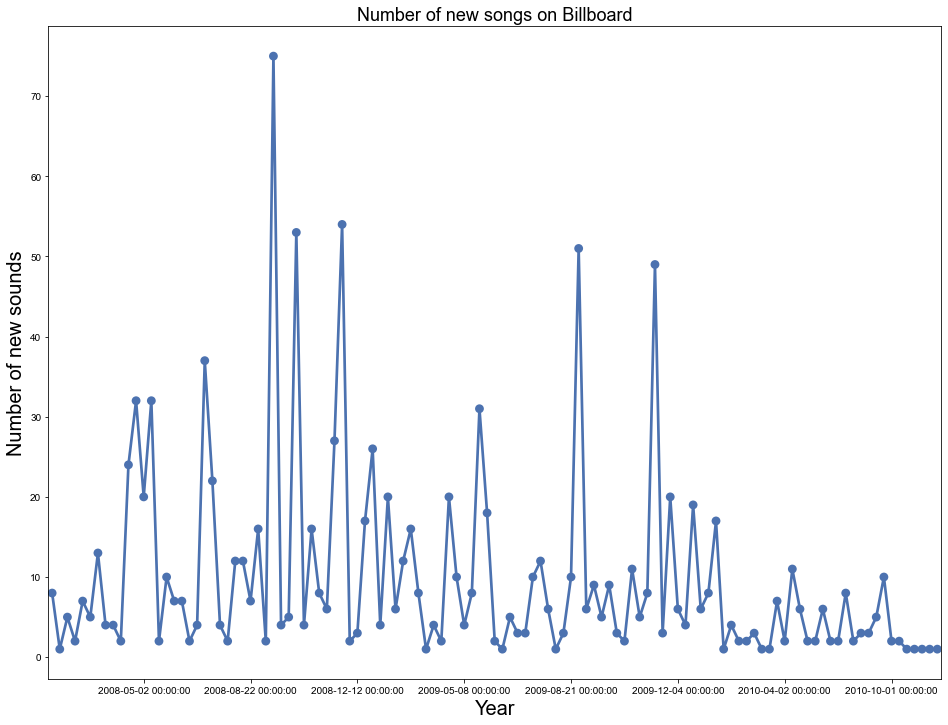

In [56]:
#Number of new songs show up on billboard everymonth

figure,ax = plt.subplots(figsize=(16, 12))
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'axes.grid' : False})

columns = ['isnew']


# df = bill[ (bill['date'] >= '2020-01-01') 
#           &(bill['date'] <= '2022-02-19') & (bill['isnew']) ]
df = bill_s_ms_merge_cut[(bill_s_ms_merge_cut['date_x'].dt.date >= date(2008,1,1))
          &(bill_s_ms_merge_cut['date_x'].dt.date <= date(2012,1,1)) & bill_s_ms_merge_cut['isnew'] ]


dfnew = df.groupby(["date_x"])[columns].count()

dfnew.columns = ['isnewCount']
ax= sns.pointplot(x = dfnew.index, y = dfnew['isnewCount'])
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))

ax.set_title('Number of new songs on Billboard')
ax.set_ylabel('Number of new sounds' , fontsize=20)
ax.set_xlabel('Year' , fontsize=20)
 
 

Text(0.5, 0, 'Year')

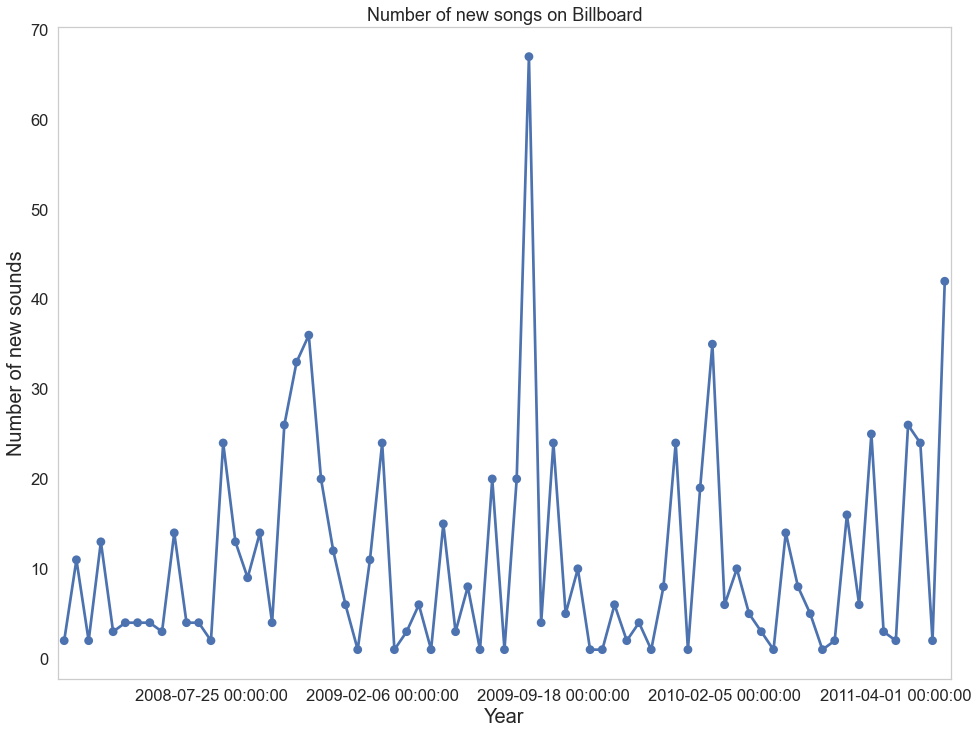

In [57]:
#Number of new songs show up on billboard everymonth

figure,ax = plt.subplots(figsize=(16, 12))
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'axes.grid' : False})



# df = bill[ (bill['date'] >= '2020-01-01') 
#           &(bill['date'] <= '2022-02-19') & (bill['isnew']) ]
fr_df = fr_bill_s_ms_merge_cut[(fr_bill_s_ms_merge_cut['date_x'].dt.date >= date(2008,1,1))
          &(fr_bill_s_ms_merge_cut['date_x'].dt.date <= date(2012,1,1)) & fr_bill_s_ms_merge_cut['isnew'] ]


fr_dfnew = fr_df.groupby(["date_x"])[columns].count()

fr_dfnew.columns = ['isnewCount']
fr_ax= sns.pointplot(x = fr_dfnew.index, y = fr_dfnew['isnewCount'])
fr_ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))

fr_ax.set_title('Number of new songs on Billboard')
fr_ax.set_ylabel('Number of new sounds' , fontsize=20)
fr_ax.set_xlabel('Year' , fontsize=20)
 
 

Text(0.5, 0, 'Year')

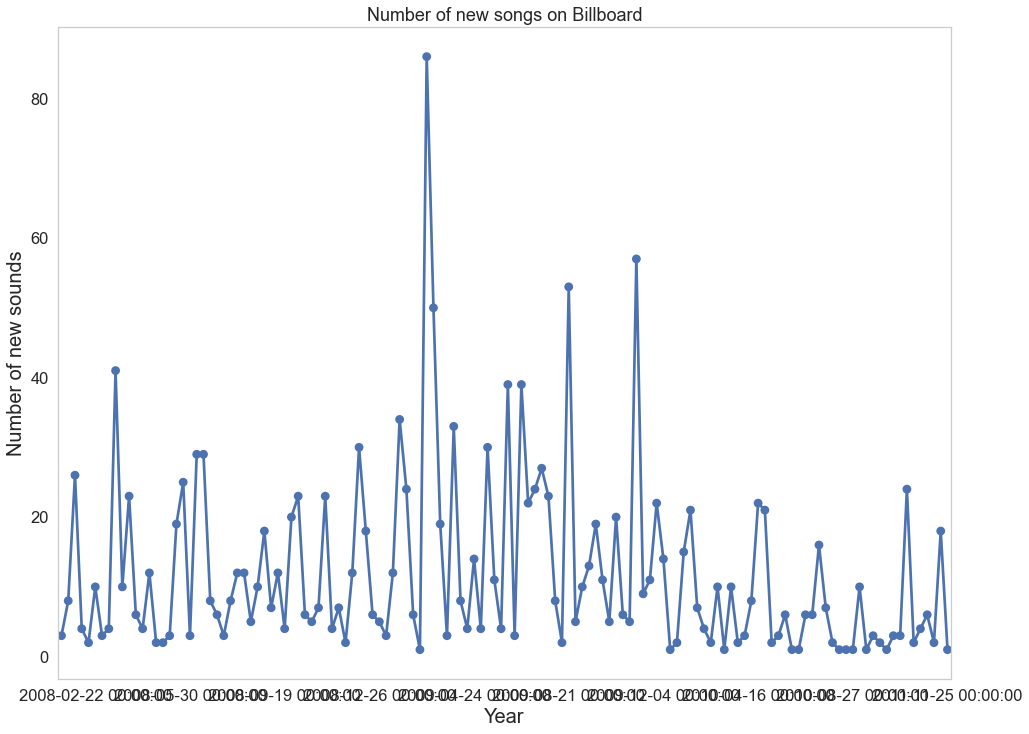

In [58]:
#Number of new songs show up on billboard everymonth

figure,ax = plt.subplots(figsize=(16, 12))
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'axes.grid' : False})

columns = ['isnew']
  

# df = bill[ (bill['date'] >= '2020-01-01') 
#           &(bill['date'] <= '2022-02-19') & (bill['isnew']) ]
df = uk_bill_s_ms_merge_cut[(uk_bill_s_ms_merge_cut['date_x'].dt.date >= date(2008,1,1))
          &(uk_bill_s_ms_merge_cut['date_x'].dt.date <= date(2012,1,1)) & uk_bill_s_ms_merge_cut['isnew'] ]


dfnew = df.groupby(["date_x"])[columns].count()

dfnew.columns = ['isnewCount']
ax= sns.pointplot(x = dfnew.index, y = dfnew['isnewCount'])
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))

ax.set_title('Number of new songs on Billboard')
ax.set_ylabel('Number of new sounds' , fontsize=20)
ax.set_xlabel('Year' , fontsize=20)
 
 

## 3.1 Extract important features from Dataset


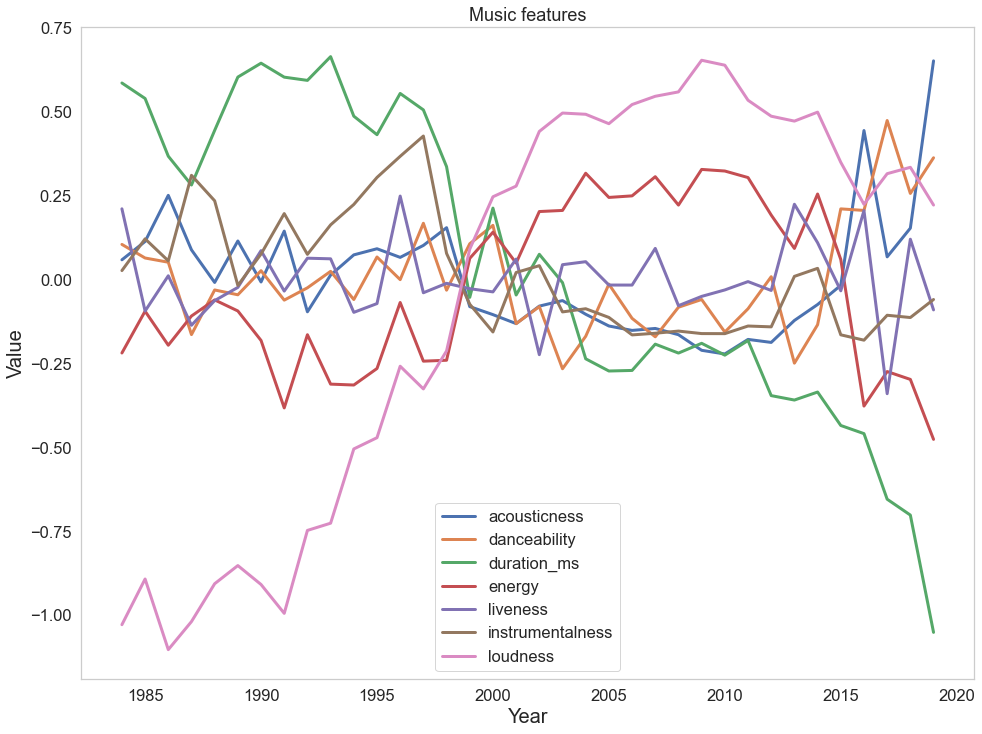

In [62]:
figure,ax = plt.subplots(figsize=(16, 12))
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'axes.grid' : False})

columns = ["acousticness","danceability","duration_ms","energy",
         "liveness",'instrumentalness',"loudness"] 

#columns = ["energy","tempo","valence"] 

          
for value in columns: 
    # df = bill_s_merge[ (bill_s_merge['date_chart'] >= '1980-01-01') 
    #       &(bill_s_merge['date_chart'] <= '2022-01-01')].copy()
    df = bill_s_merge_cut[ (bill_s_merge_cut['date_x'].dt.date >= date(1980,1,1)) 
          &(bill_s_merge_cut['date_x'].dt.date <= date(2020,1,1))].copy() 
    df[value] = (df[value] - df[value].mean()) / df[value].std()
    df['year'] = pd.DatetimeIndex(df['date_x']).year
    x = df.groupby("year")[value].mean()
    ax= sns.lineplot(x=x.index,y=x,label=value, linewidth = 3)
    
ax.set_title('Music features')
ax.set_ylabel('Value' , fontsize=20)
ax.set_xlabel('Year' , fontsize=20);

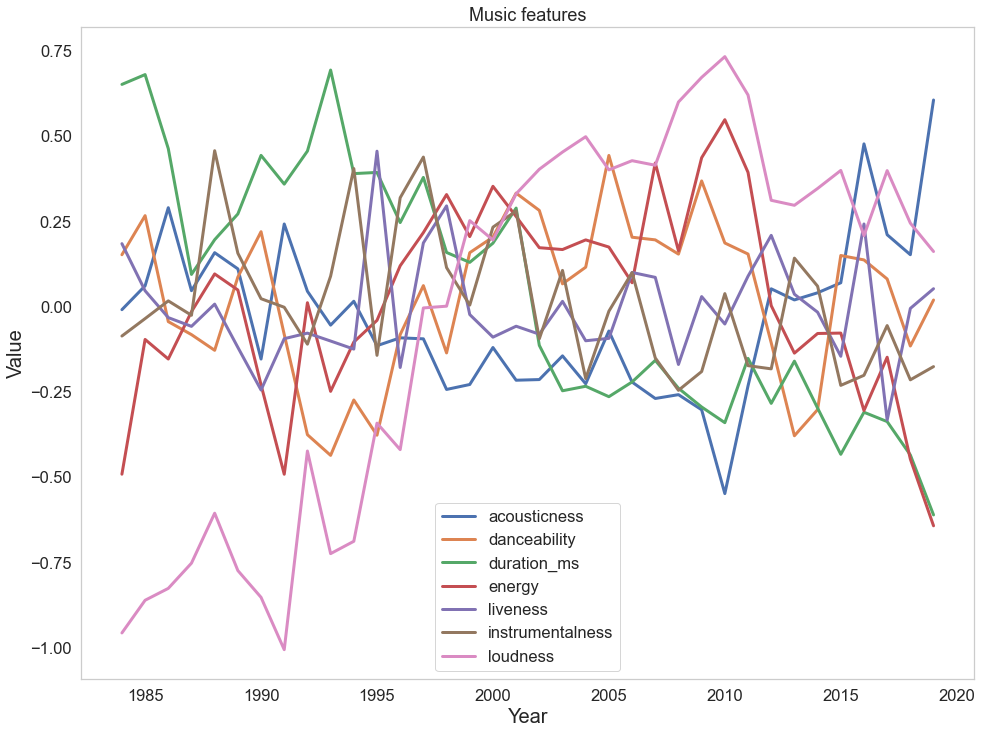

In [63]:
figure,ax = plt.subplots(figsize=(16, 12))
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'axes.grid' : False})

columns = ["acousticness","danceability","duration_ms","energy",
         "liveness",'instrumentalness',"loudness"] 

#columns = ["energy","tempo","valence"] 

          
for value in columns: 
    # df = bill_s_merge[ (bill_s_merge['date_chart'] >= '1980-01-01') 
    #       &(bill_s_merge['date_chart'] <= '2022-01-01')].copy()
    df = fr_bill_s_merge_cut[ (fr_bill_s_merge_cut['date_x'].dt.date >= date(1980,1,1)) 
          &(fr_bill_s_merge_cut['date_x'].dt.date <= date(2020,1,1))].copy() 
    df[value] = (df[value] - df[value].mean()) / df[value].std()
    df['year'] = pd.DatetimeIndex(df['date_x']).year
    x = df.groupby("year")[value].mean()
    ax= sns.lineplot(x=x.index,y=x,label=value, linewidth = 3)
    
ax.set_title('Music features')
ax.set_ylabel('Value' , fontsize=20)
ax.set_xlabel('Year' , fontsize=20);

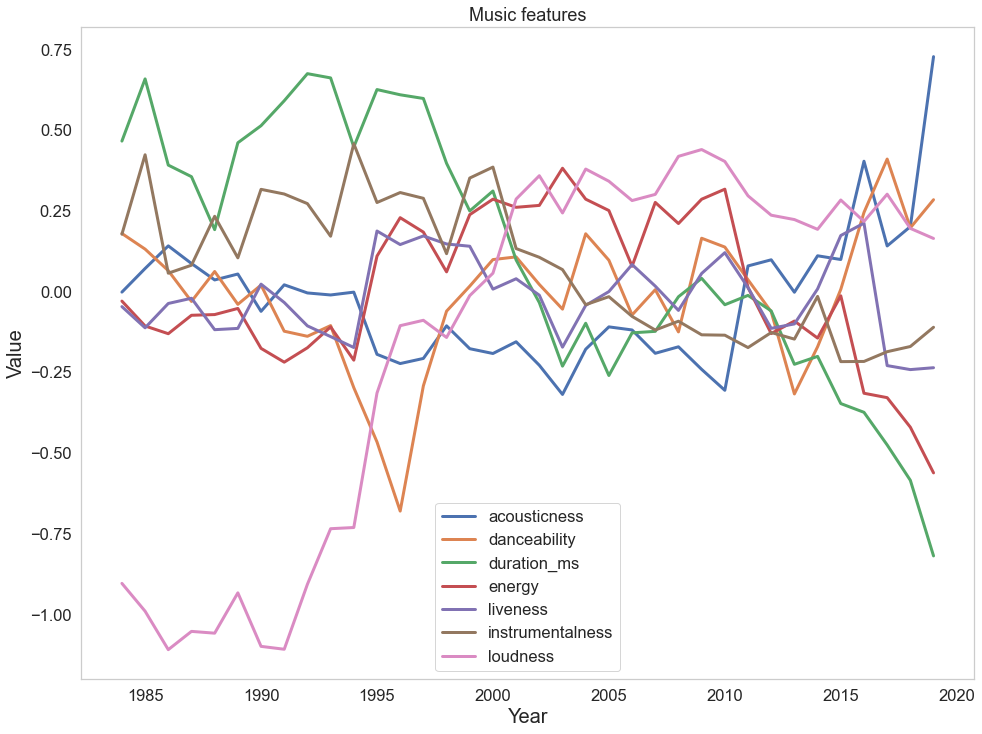

In [64]:
figure,ax = plt.subplots(figsize=(16, 12))
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'axes.grid' : False})

columns = ["acousticness","danceability","duration_ms","energy",
         "liveness",'instrumentalness',"loudness"] 

#columns = ["energy","tempo","valence"] 

          
for value in columns: 
    # df = bill_s_merge[ (bill_s_merge['date_chart'] >= '1980-01-01') 
    #       &(bill_s_merge['date_chart'] <= '2022-01-01')].copy()
    df = uk_bill_s_merge_cut[ (uk_bill_s_merge_cut['date_x'].dt.date >= date(1980,1,1)) 
          &(uk_bill_s_merge_cut['date_x'].dt.date <= date(2020,1,1))].copy() 
    df[value] = (df[value] - df[value].mean()) / df[value].std()
    df['year'] = pd.DatetimeIndex(df['date_x']).year
    x = df.groupby("year")[value].mean()
    ax= sns.lineplot(x=x.index,y=x,label=value, linewidth = 3)
    
ax.set_title('Music features')
ax.set_ylabel('Value' , fontsize=20)
ax.set_xlabel('Year' , fontsize=20);

#### 3.1.2.1 Loudness change is similar (increasing) in three countries

Text(0.5, 0, 'Year')

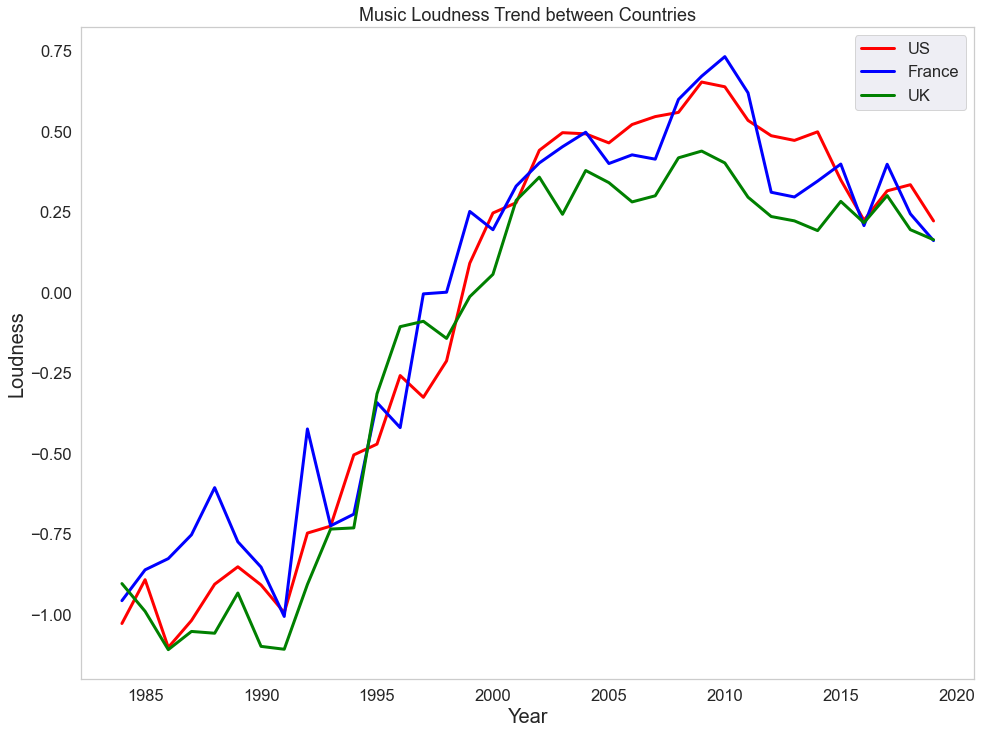

In [65]:
figure,ax = plt.subplots(figsize=(16, 12))
sns.set(font_scale=1.5)
# sns.set_style("whitegrid", {'axes.grid' : False})

columns = ["loudness"] 
          
for value in columns: 
    df = bill_s_merge_cut[ (bill_s_merge_cut['date_x'].dt.date >= date(1980,1,1)) 
          &(bill_s_merge_cut['date_x'].dt.date <= date(2020,1,1))].copy() 
    df[value] = (df[value] - df[value].mean()) / df[value].std()
    df['year'] = pd.DatetimeIndex(df['date_x']).year
    x = df.groupby("year")[value].mean()
    ax= sns.lineplot(x=x.index,y=x,label='US',color='red',linewidth = 3)

    df = fr_bill_s_merge_cut[ (fr_bill_s_merge_cut['date_x'].dt.date >= date(1980,1,1)) 
          &(fr_bill_s_merge_cut['date_x'].dt.date <= date(2020,1,1))].copy() 
    df[value] = (df[value] - df[value].mean()) / df[value].std()
    df['year'] = pd.DatetimeIndex(df['date_x']).year
    x = df.groupby("year")[value].mean()
    ax= sns.lineplot(x=x.index,y=x,label='France',color='blue',linewidth = 3)

    df = uk_bill_s_merge_cut[ (uk_bill_s_merge_cut['date_x'].dt.date >= date(1980,1,1)) 
          &(uk_bill_s_merge_cut['date_x'].dt.date <= date(2020,1,1))].copy() 
    df[value] = (df[value] - df[value].mean()) / df[value].std()
    df['year'] = pd.DatetimeIndex(df['date_x']).year
    x = df.groupby("year")[value].mean()
    ax= sns.lineplot(x=x.index,y=x,label='UK',color='green',linewidth = 3)

    
ax.set_title('Music Loudness Trend between Countries')

ax.set_ylabel('Loudness' , fontsize=20)
ax.set_xlabel('Year' , fontsize=20)

#### 3.1.2.2 Duration of Songs change is similar (decreasing) in three countries

Text(0.5, 0, 'Year')

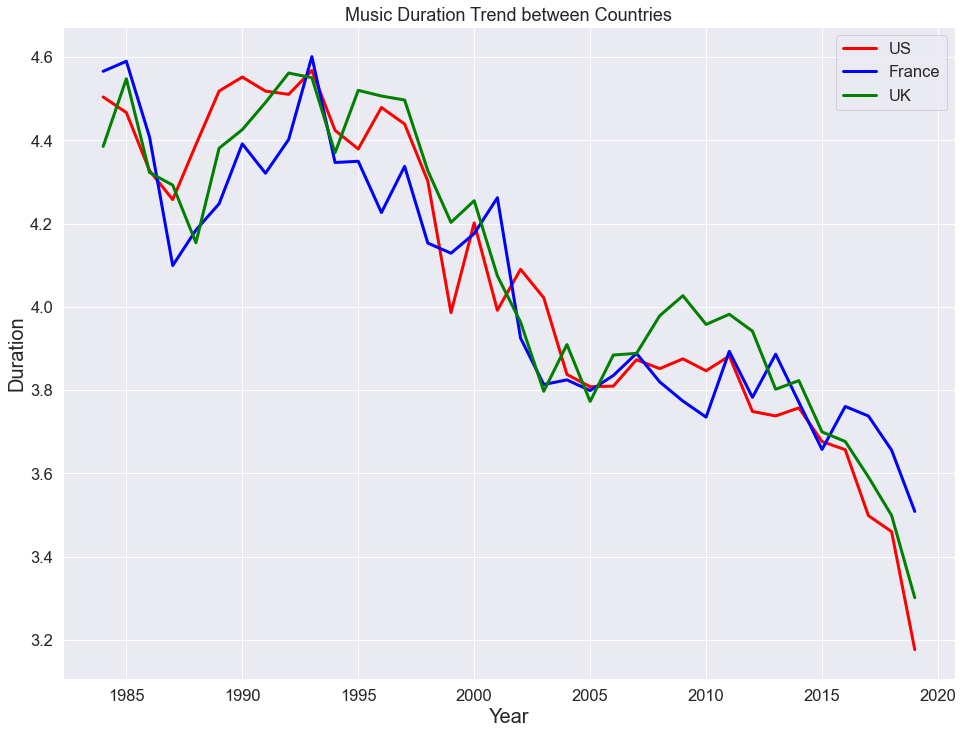

In [66]:
figure,ax = plt.subplots(figsize=(16, 12))
sns.set(font_scale=1.5)
# sns.set_style("whitegrid", {'axes.grid' : False})

columns = ["duration_ms"] 
          
for value in columns: 
    df = bill_s_merge_cut[ (bill_s_merge_cut['date_x'].dt.date >= date(1980,1,1)) 
          &(bill_s_merge_cut['date_x'].dt.date <= date(2020,1,1))].copy() 
    df[value] = (df[value]) / 60000
    df['year'] = pd.DatetimeIndex(df['date_x']).year
    x = df.groupby("year")[value].mean()
    ax= sns.lineplot(x=x.index,y=x,label='US',color='red',linewidth = 3)

    df = fr_bill_s_merge_cut[ (fr_bill_s_merge_cut['date_x'].dt.date >= date(1980,1,1)) 
          &(fr_bill_s_merge_cut['date_x'].dt.date <= date(2020,1,1))].copy() 
    df[value] = (df[value]) / 60000
    df['year'] = pd.DatetimeIndex(df['date_x']).year
    x = df.groupby("year")[value].mean()
    ax= sns.lineplot(x=x.index,y=x,label='France',color='blue',linewidth = 3)

    df = uk_bill_s_merge_cut[ (uk_bill_s_merge_cut['date_x'].dt.date >= date(1980,1,1)) 
          &(uk_bill_s_merge_cut['date_x'].dt.date <= date(2020,1,1))].copy() 
    df[value] = (df[value]) / 60000
    df['year'] = pd.DatetimeIndex(df['date_x']).year
    x = df.groupby("year")[value].mean()
    ax= sns.lineplot(x=x.index,y=x,label='UK',color='green',linewidth = 3)

    
ax.set_title('Music Duration Trend between Countries')

ax.set_ylabel('Duration' , fontsize=20)
ax.set_xlabel('Year' , fontsize=20)

#### 3.1.2.3 Acousticness of Songs Trend Over the years

Text(0.5, 0, 'Year')

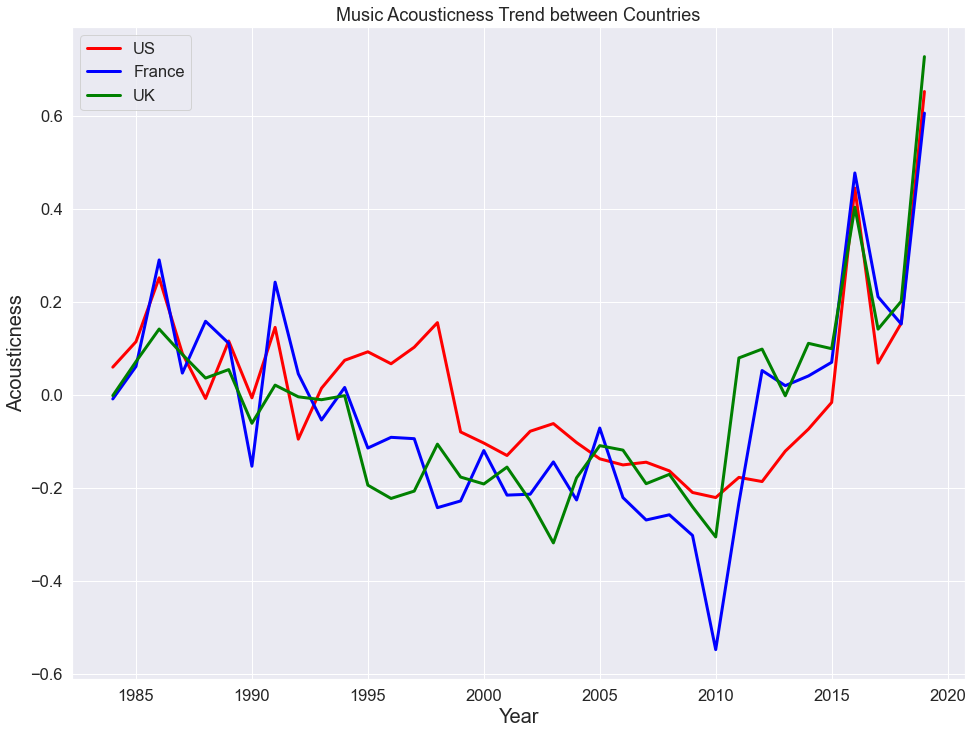

In [67]:
figure,ax = plt.subplots(figsize=(16, 12))
sns.set(font_scale=1.5)
# sns.set_style("whitegrid", {'axes.grid' : False})


columns = ["acousticness"] 

for value in columns: 
    df = bill_s_merge_cut[ (bill_s_merge_cut['date_x'].dt.date >= date(1980,1,1)) 
          &(bill_s_merge_cut['date_x'].dt.date <= date(2020,1,1))].copy() 
    df[value] = (df[value] - df[value].mean()) / df[value].std()
    df['year'] = pd.DatetimeIndex(df['date_x']).year
    x = df.groupby("year")[value].mean()
    ax= sns.lineplot(x=x.index,y=x,label='US',color='red',linewidth = 3)

    df = fr_bill_s_merge_cut[ (fr_bill_s_merge_cut['date_x'].dt.date >= date(1980,1,1)) 
          &(fr_bill_s_merge_cut['date_x'].dt.date <= date(2020,1,1))].copy() 
    df[value] = (df[value] - df[value].mean()) / df[value].std()
    df['year'] = pd.DatetimeIndex(df['date_x']).year
    x = df.groupby("year")[value].mean()
    ax= sns.lineplot(x=x.index,y=x,label='France',color='blue',linewidth = 3)

    df = uk_bill_s_merge_cut[ (uk_bill_s_merge_cut['date_x'].dt.date >= date(1980,1,1)) 
          &(uk_bill_s_merge_cut['date_x'].dt.date <= date(2020,1,1))].copy() 
    df[value] = (df[value] - df[value].mean()) / df[value].std()
    df['year'] = pd.DatetimeIndex(df['date_x']).year
    x = df.groupby("year")[value].mean()
    ax= sns.lineplot(x=x.index,y=x,label='UK',color='green',linewidth = 3)


    
ax.set_title('Music Acousticness Trend between Countries')

ax.set_ylabel('Acousticness' , fontsize=20)
ax.set_xlabel('Year' , fontsize=20)

#### 3.1.2.4 Danceability of Songs Trend Over the years

Text(0.5, 0, 'Year')

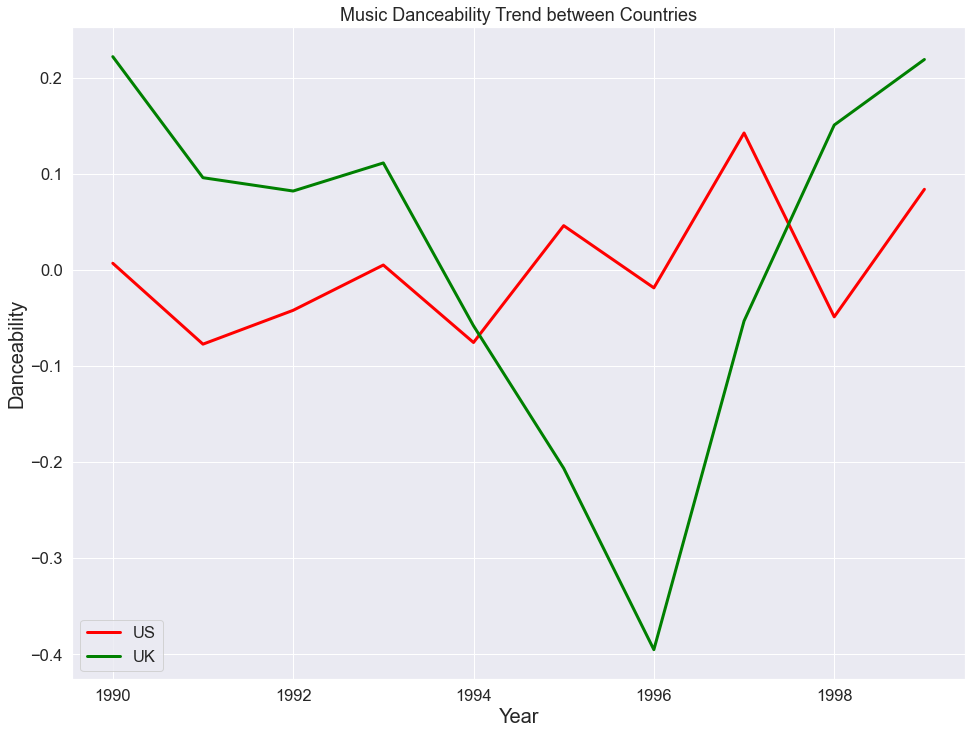

In [68]:
figure,ax = plt.subplots(figsize=(16, 12))
sns.set(font_scale=1.5)
# sns.set_style("whitegrid", {'axes.grid' : False})


columns = ["danceability"] 

          
for value in columns: 
    # df = bill_s_merge_cut[ (bill_s_merge_cut['date_x'].dt.date >= date(1980,1,1)) 
    #       &(bill_s_merge_cut['date_x'].dt.date <= date(2020,1,1))].copy() 
    # df[value] = (df[value] - df[value].mean()) / df[value].std()
    # df['year'] = pd.DatetimeIndex(df['date_x']).year
    # x = df.groupby("year")[value].mean()
    # ax= sns.lineplot(x=x.index,y=x,label='US',color='red',linewidth = 3)

    # df = fr_bill_s_merge_cut[ (fr_bill_s_merge_cut['date_x'].dt.date >= date(1980,1,1)) 
    #       &(fr_bill_s_merge_cut['date_x'].dt.date <= date(2020,1,1))].copy() 
    # df[value] = (df[value] - df[value].mean()) / df[value].std()
    # df['year'] = pd.DatetimeIndex(df['date_x']).year
    # x = df.groupby("year")[value].mean()
    # ax= sns.lineplot(x=x.index,y=x,label='France',color='blue',linewidth = 3)

    # df = uk_bill_s_merge_cut[ (uk_bill_s_merge_cut['date_x'].dt.date >= date(1980,1,1)) 
    #       &(uk_bill_s_merge_cut['date_x'].dt.date <= date(2020,1,1))].copy() 
    # df[value] = (df[value] - df[value].mean()) / df[value].std()
    # df['year'] = pd.DatetimeIndex(df['date_x']).year
    # x = df.groupby("year")[value].mean()
    # ax= sns.lineplot(x=x.index,y=x,label='UK',color='green',linewidth = 3)

    df = bill_s_merge_cut[ (bill_s_merge_cut['date_x'].dt.date >= date(1990,1,1)) 
          &(bill_s_merge_cut['date_x'].dt.date <= date(2000,1,1))].copy() 
    df[value] = (df[value] - df[value].mean()) / df[value].std()
    df['year'] = pd.DatetimeIndex(df['date_x']).year
    x = df.groupby("year")[value].mean()
    ax= sns.lineplot(x=x.index,y=x,label='US',color='red',linewidth = 3)

    # df = fr_bill_s_merge_cut[ (fr_bill_s_merge_cut['date_x'].dt.date >= date(1990,1,1)) 
    #       &(fr_bill_s_merge_cut['date_x'].dt.date <= date(2000,1,1))].copy() 
    # df[value] = (df[value] - df[value].mean()) / df[value].std()
    # df['year'] = pd.DatetimeIndex(df['date_x']).year
    # x = df.groupby("year")[value].mean()
    # ax= sns.lineplot(x=x.index,y=x,label='France',color='blue',linewidth = 3)

    df = uk_bill_s_merge_cut[ (uk_bill_s_merge_cut['date_x'].dt.date >= date(1990,1,1)) 
          &(uk_bill_s_merge_cut['date_x'].dt.date <= date(2000,1,1))].copy() 
    df[value] = (df[value] - df[value].mean()) / df[value].std()
    df['year'] = pd.DatetimeIndex(df['date_x']).year
    x = df.groupby("year")[value].mean()
    ax= sns.lineplot(x=x.index,y=x,label='UK',color='green',linewidth = 3)


    
ax.set_title('Music Danceability Trend between Countries')

ax.set_ylabel('Danceability' , fontsize=20)
ax.set_xlabel('Year' , fontsize=20)

#### 3.1.2.5 Energy of Songs Trend Over the years

Text(0.5, 0, 'Year')

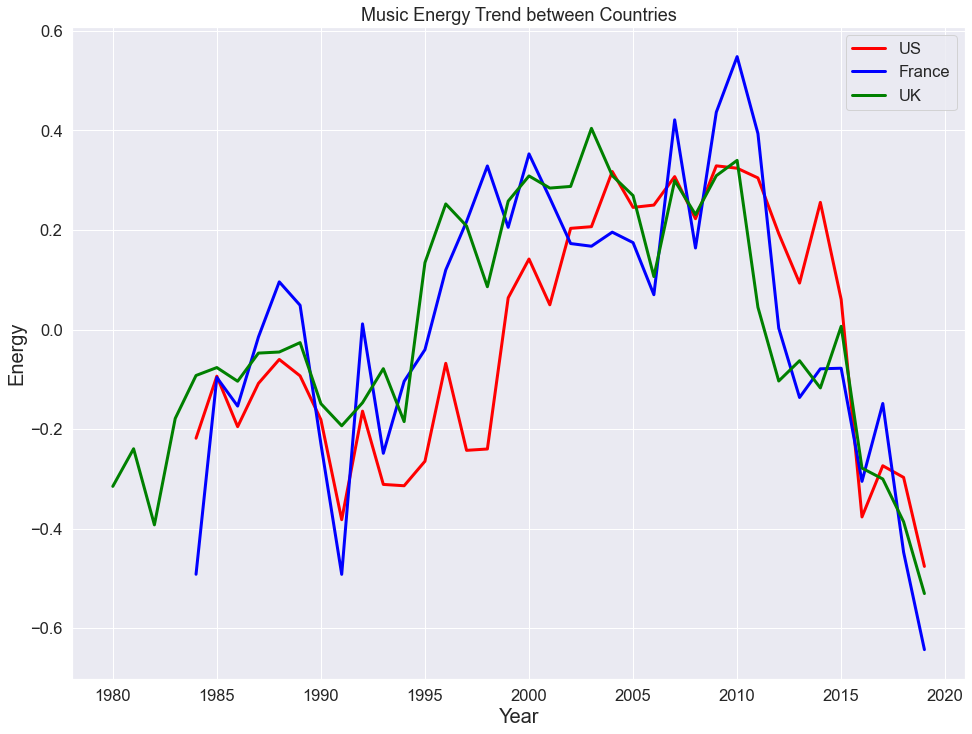

In [69]:
figure,ax = plt.subplots(figsize=(16, 12))
sns.set(font_scale=1.5)
# sns.set_style("whitegrid", {'axes.grid' : False})


columns = ["energy"] 

          
for value in columns: 
    df = bill_s_merge_cut[ (bill_s_merge_cut['date_x'].dt.date >= date(1980,1,1)) 
          &(bill_s_merge_cut['date_x'].dt.date <= date(2020,1,1))].copy() 
    df[value] = (df[value] - df[value].mean()) / df[value].std()
    df['year'] = pd.DatetimeIndex(df['date_x']).year
    x = df.groupby("year")[value].mean()
    ax= sns.lineplot(x=x.index,y=x,label='US',color='red',linewidth = 3)

    df = fr_bill_s_merge_cut[ (fr_bill_s_merge_cut['date_x'].dt.date >= date(1980,1,1)) 
          &(fr_bill_s_merge_cut['date_x'].dt.date <= date(2020,1,1))].copy() 
    df[value] = (df[value] - df[value].mean()) / df[value].std()
    df['year'] = pd.DatetimeIndex(df['date_x']).year
    x = df.groupby("year")[value].mean()
    ax= sns.lineplot(x=x.index,y=x,label='France',color='blue',linewidth = 3)

    df = uk_bill_s_merge[ (uk_bill_s_merge['date_x'].dt.date >= date(1980,1,1)) 
          &(uk_bill_s_merge['date_x'].dt.date <= date(2020,1,1))].copy() 
    df[value] = (df[value] - df[value].mean()) / df[value].std()
    df['year'] = pd.DatetimeIndex(df['date_x']).year
    x = df.groupby("year")[value].mean()
    ax= sns.lineplot(x=x.index,y=x,label='UK',color='green',linewidth = 3)


    
ax.set_title('Music Energy Trend between Countries')

ax.set_ylabel('Energy' , fontsize=20)
ax.set_xlabel('Year' , fontsize=20)

#### 3.1.2.6 Liveness of Songs Trend Over the years


Text(0.5, 0, 'Year')

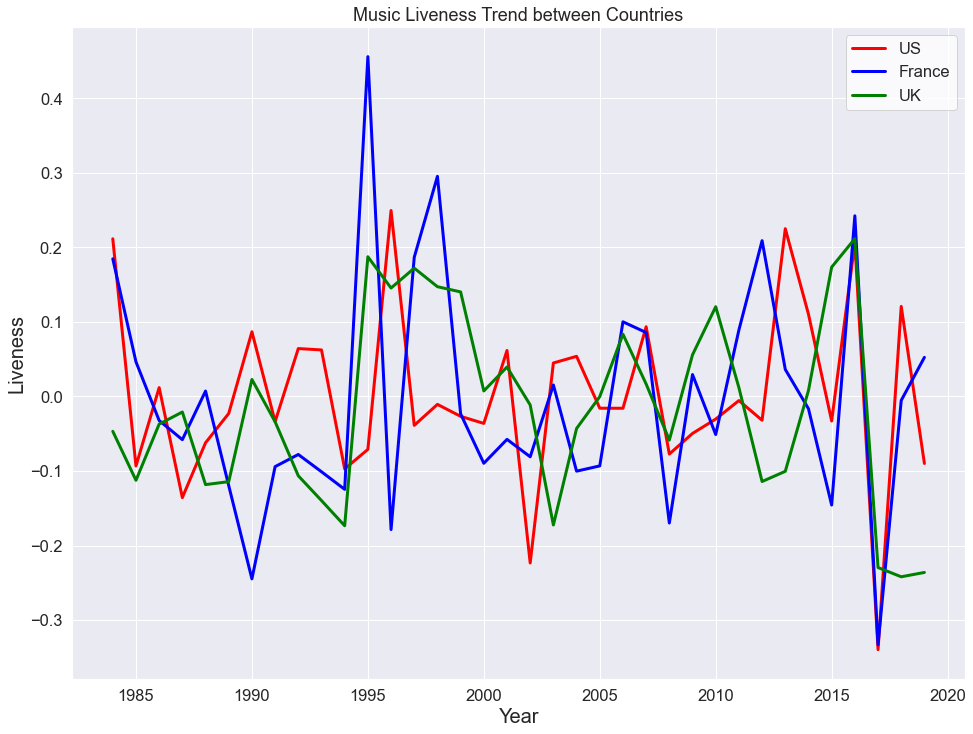

In [70]:
figure,ax = plt.subplots(figsize=(16, 12))
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'axes.grid' : False})


columns = ["liveness"] 

          
for value in columns: 
    df = bill_s_merge_cut[ (bill_s_merge_cut['date_x'].dt.date >= date(1980,1,1)) 
          &(bill_s_merge_cut['date_x'].dt.date <= date(2020,1,1))].copy() 
    df[value] = (df[value] - df[value].mean()) / df[value].std()
    df['year'] = pd.DatetimeIndex(df['date_x']).year
    x = df.groupby("year")[value].mean()
    ax= sns.lineplot(x=x.index,y=x,label='US',color='red',linewidth = 3)

    df = fr_bill_s_merge_cut[ (fr_bill_s_merge_cut['date_x'].dt.date >= date(1980,1,1)) 
          &(fr_bill_s_merge_cut['date_x'].dt.date <= date(2020,1,1))].copy() 
    df[value] = (df[value] - df[value].mean()) / df[value].std()
    df['year'] = pd.DatetimeIndex(df['date_x']).year
    x = df.groupby("year")[value].mean()
    ax= sns.lineplot(x=x.index,y=x,label='France',color='blue',linewidth = 3)

    df = uk_bill_s_merge_cut[ (uk_bill_s_merge_cut['date_x'].dt.date >= date(1980,1,1)) 
          &(uk_bill_s_merge_cut['date_x'].dt.date <= date(2020,1,1))].copy() 
    df[value] = (df[value] - df[value].mean()) / df[value].std()
    df['year'] = pd.DatetimeIndex(df['date_x']).year
    x = df.groupby("year")[value].mean()
    ax= sns.lineplot(x=x.index,y=x,label='UK',color='green',linewidth = 3)

    # df = fr_bill_s_merge_cut[ (fr_bill_s_merge_cut['date_x'].dt.date >= date(1984,1,1)) 
    #       &(fr_bill_s_merge_cut['date_x'].dt.date <= date(1994,1,1))].copy() 
    # df[value] = (df[value] - df[value].mean()) / df[value].std()
    # df['year'] = pd.DatetimeIndex(df['date_x']).year
    # x = df.groupby("year")[value].mean()
    # ax= sns.lineplot(x=x.index,y=x,label='France',color='blue',linewidth = 3)

    # df = uk_bill_s_merge_cut[ (uk_bill_s_merge_cut['date_x'].dt.date >= date(1984,1,1)) 
    #       &(uk_bill_s_merge_cut['date_x'].dt.date <= date(1994,1,1))].copy() 
    # df[value] = (df[value] - df[value].mean()) / df[value].std()
    # df['year'] = pd.DatetimeIndex(df['date_x']).year
    # x = df.groupby("year")[value].mean()
    # ax= sns.lineplot(x=x.index,y=x,label='UK',color='green',linewidth = 3)


    
ax.set_title('Music Liveness Trend between Countries')

ax.set_ylabel('Liveness' , fontsize=20)
ax.set_xlabel('Year' , fontsize=20)

#### 3.1.27 Instrumentalness of Songs Trend Over the years

Text(0.5, 0, 'Year')

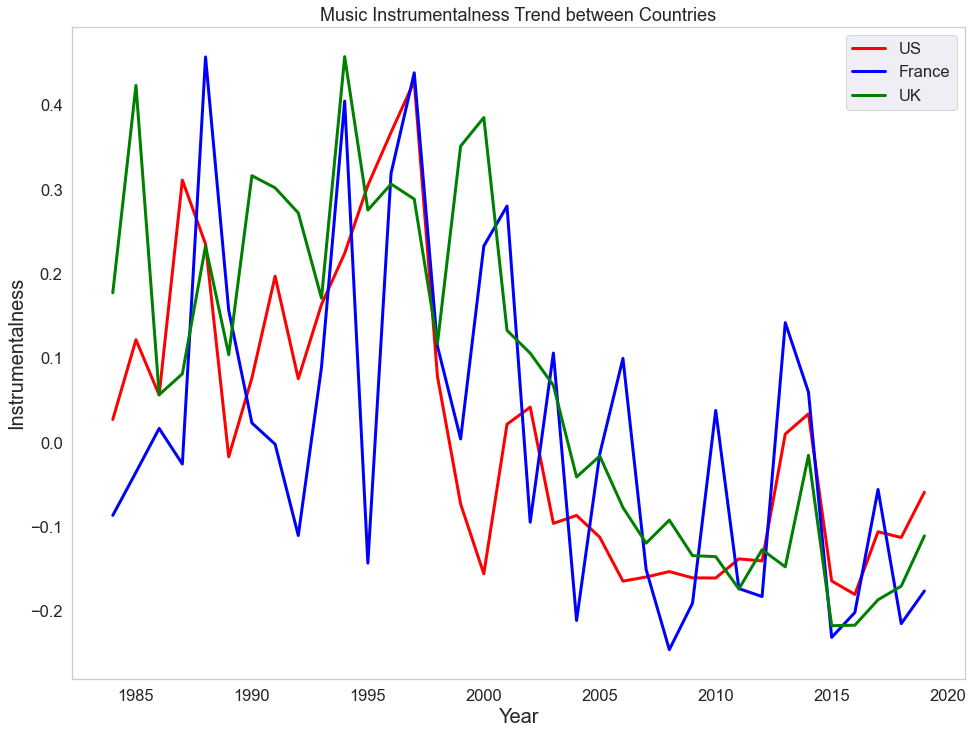

In [71]:
figure,ax = plt.subplots(figsize=(16, 12))
sns.set(font_scale=1.5)
# sns.set_style("whitegrid", {'axes.grid' : False})


columns = ["instrumentalness"] 

          
for value in columns: 
    df = bill_s_merge_cut[ (bill_s_merge_cut['date_x'].dt.date >= date(1980,1,1)) 
          &(bill_s_merge_cut['date_x'].dt.date <= date(2020,1,1))].copy() 
    df[value] = (df[value] - df[value].mean()) / df[value].std()
    df['year'] = pd.DatetimeIndex(df['date_x']).year
    x = df.groupby("year")[value].mean()
    ax= sns.lineplot(x=x.index,y=x,label='US',color='red',linewidth = 3)

    df = fr_bill_s_merge_cut[ (fr_bill_s_merge_cut['date_x'].dt.date >= date(1980,1,1)) 
          &(fr_bill_s_merge_cut['date_x'].dt.date <= date(2020,1,1))].copy() 
    df[value] = (df[value] - df[value].mean()) / df[value].std()
    df['year'] = pd.DatetimeIndex(df['date_x']).year
    x = df.groupby("year")[value].mean()
    ax= sns.lineplot(x=x.index,y=x,label='France',color='blue',linewidth = 3)

    df = uk_bill_s_merge_cut[ (uk_bill_s_merge_cut['date_x'].dt.date >= date(1980,1,1)) 
          &(uk_bill_s_merge_cut['date_x'].dt.date <= date(2020,1,1))].copy() 
    df[value] = (df[value] - df[value].mean()) / df[value].std()
    df['year'] = pd.DatetimeIndex(df['date_x']).year
    x = df.groupby("year")[value].mean()
    ax= sns.lineplot(x=x.index,y=x,label='UK',color='green',linewidth = 3)


    
ax.set_title('Music Instrumentalness Trend between Countries')

ax.set_ylabel('Instrumentalness' , fontsize=20)
ax.set_xlabel('Year' , fontsize=20)

### 3.1.3 Features with similiar shape of changes over Years

Text(0.5, 0, 'Year')

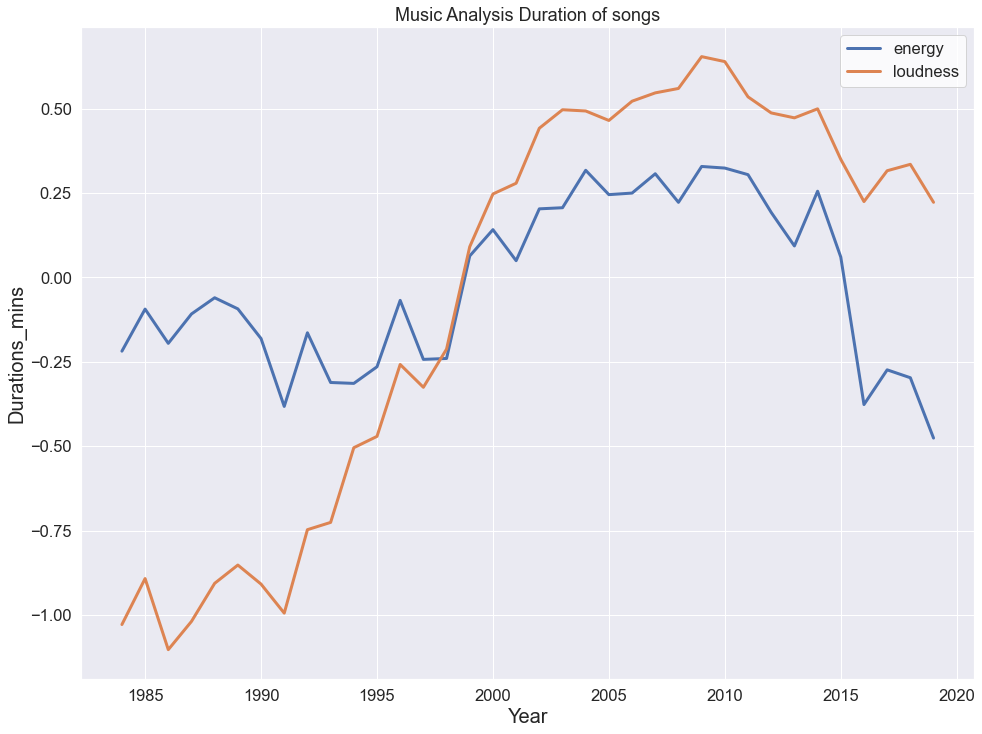

In [72]:
figure,ax = plt.subplots(figsize=(16, 12))
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'axes.grid' : False})

columns = ["energy","loudness"] 
          
for value in columns: 
    df = bill_s_merge_cut[ (bill_s_merge_cut['date_x'].dt.date >= date(1980,1,1)) 
          &(bill_s_merge_cut['date_x'].dt.date <= date(2020,1,1)) ].copy()
    df[value] = (df[value] - df[value].mean()) / df[value].std()
    df['year'] = pd.DatetimeIndex(df['date_x']).year
    x = df.groupby("year")[value].mean()
    ax= sns.lineplot(x=x.index,y=x,label=value, linewidth = 3)

    
ax.set_title('Music Analysis Duration of songs')

ax.set_ylabel('Durations_mins' , fontsize=20)
ax.set_xlabel('Year' , fontsize=20)

Text(0.5, 0, 'Year')

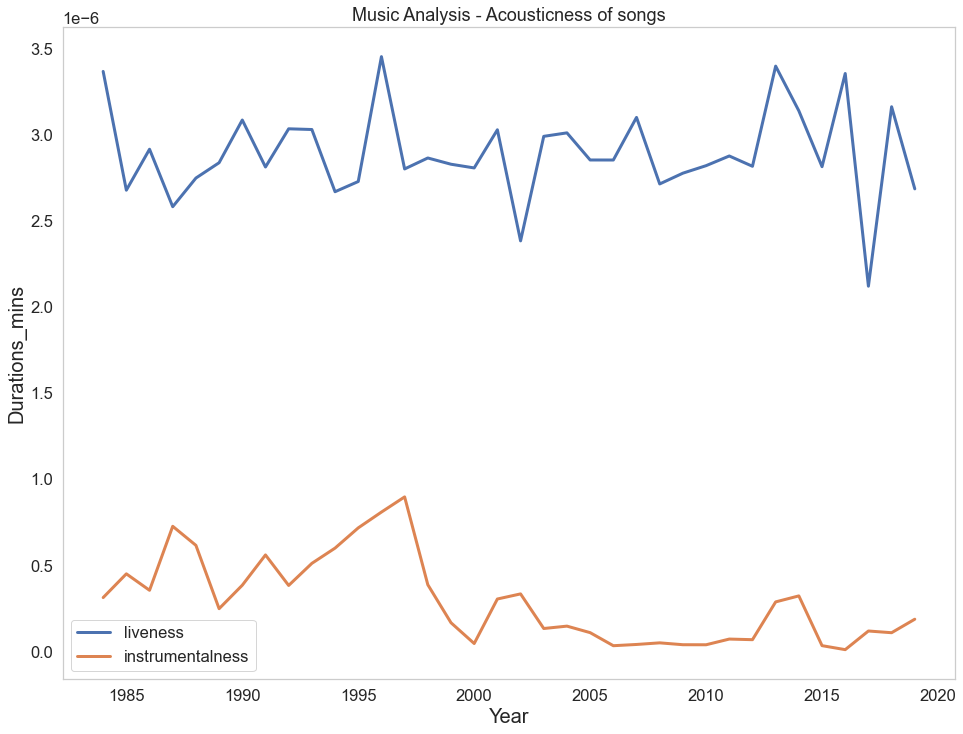

In [73]:
figure,ax = plt.subplots(figsize=(16, 12))
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'axes.grid' : False}) 

columns = ["liveness",'instrumentalness'] 

          
for value in columns: 
    df = bill_s_merge_cut[ (bill_s_merge_cut['date_x'].dt.date >= date(1980,1,1)) 
          &(bill_s_merge_cut['date_x'].dt.date <= date(2020,1,1)) ].copy()
    df[value] = (df[value]) / 60000
    df['year'] = pd.DatetimeIndex(df['date_x']).year
    x = df.groupby("year")[value].mean()
    ax= sns.lineplot(x=x.index,y=x,label=value,linewidth = 3)

    
ax.set_title('Music Analysis - Acousticness of songs')

ax.set_ylabel('Durations_mins' , fontsize=20)
ax.set_xlabel('Year' , fontsize=20)

### 3.1.4 Features with inverse relationship over Years

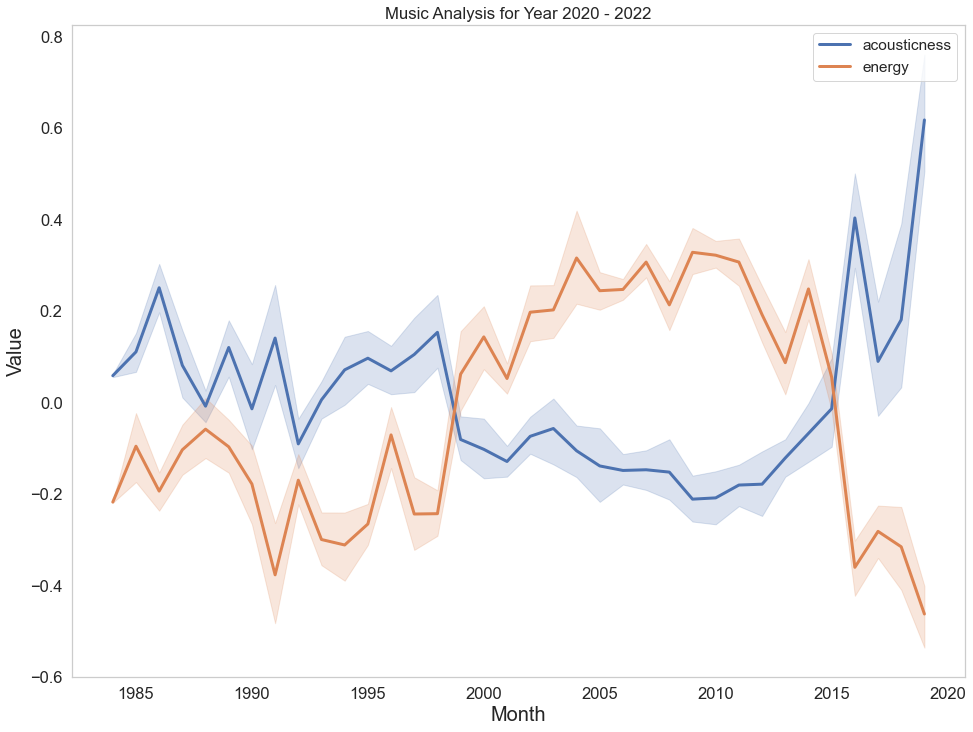

In [74]:
figure,axes = plt.subplots(figsize=(16, 12))
sns.set(style="whitegrid" , font_scale=1.4) 

columns = ["acousticness","energy"] 

 
for value in columns: 
    df = bill_s_merge_cut[ (bill_s_merge_cut['date_x'].dt.date >= date(1980,1,1)) 
          &(bill_s_merge_cut['date_x'].dt.date <= date(2020,1,1)) ].copy()
    df[value] = (df[value] - df[value].mean()) / df[value].std()
    df['month'] = pd.DatetimeIndex(df['date_x']).month
    df['year'] = pd.DatetimeIndex(df['date_x']).year
    df['year_month'] =  df['month'].map(str) + '-' + df['year'].map(str)
    x = df.groupby(['year','month','year_month'])[value].mean()
    axes = sns.lineplot(data = x, x = 'year', y=x, label=value,linewidth = 3)

    
axes.set_title('Music Analysis for Year 2020 - 2022')

ax.xaxis.set_major_locator(mdates.YearLocator())


axes.set_ylabel('Value' , fontsize=20)
axes.set_xlabel('Month' , fontsize=20)
plt.show()

# 4. Recent years Analysis - Potential Impact of Pandemic

Text(0.5, 0, 'Year')

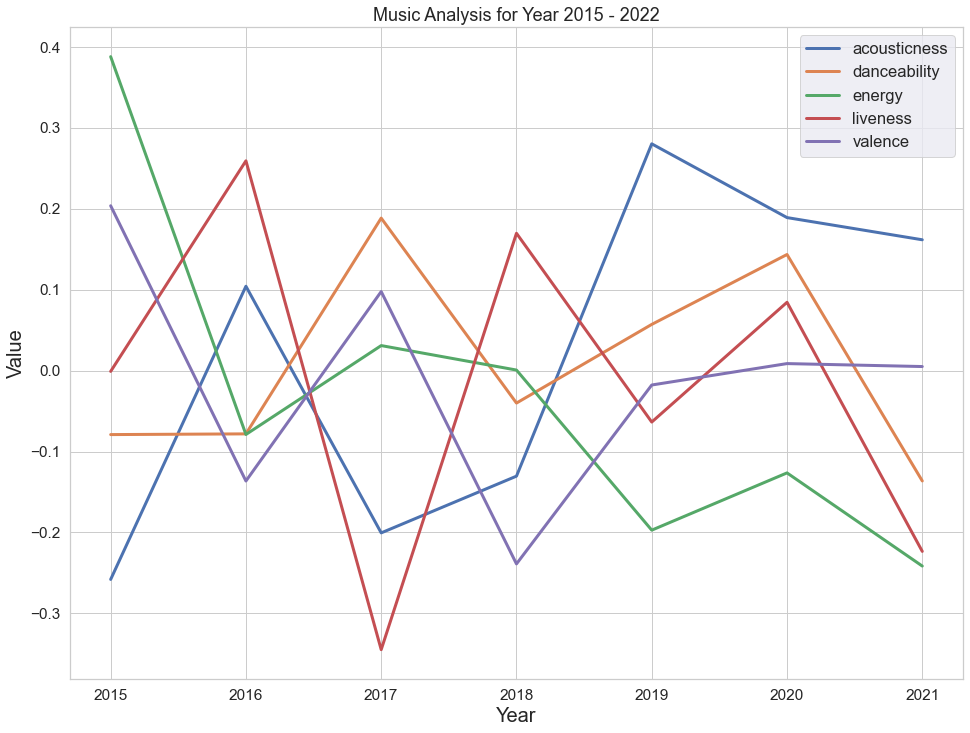

In [75]:
figure,ax = plt.subplots(figsize=(16, 12))
sns.set(font_scale=1.5)
# sns.set_style("whitegrid", {'axes.grid' : False})

columns = ["acousticness","danceability","energy",
         "liveness","valence"] 

          
for value in columns: 
    df = bill_s_merge[ (bill_s_merge['date_x'].dt.date >= date(2015,1,1))
          &(bill_s_merge['date_x'].dt.date <= date(2022,1,1)) ].copy()
    df[value] = (df[value] - df[value].mean()) / df[value].std()
    df['year'] = pd.DatetimeIndex(df['date_x']).year
    x = df.groupby("year")[value].mean()
    ax= sns.lineplot(x=x.index,y=x,label=value,linewidth = 3)

    
ax.set_title('Music Analysis for Year 2015 - 2022')

ax.set_ylabel('Value' , fontsize=20)
ax.set_xlabel('Year' , fontsize=20)

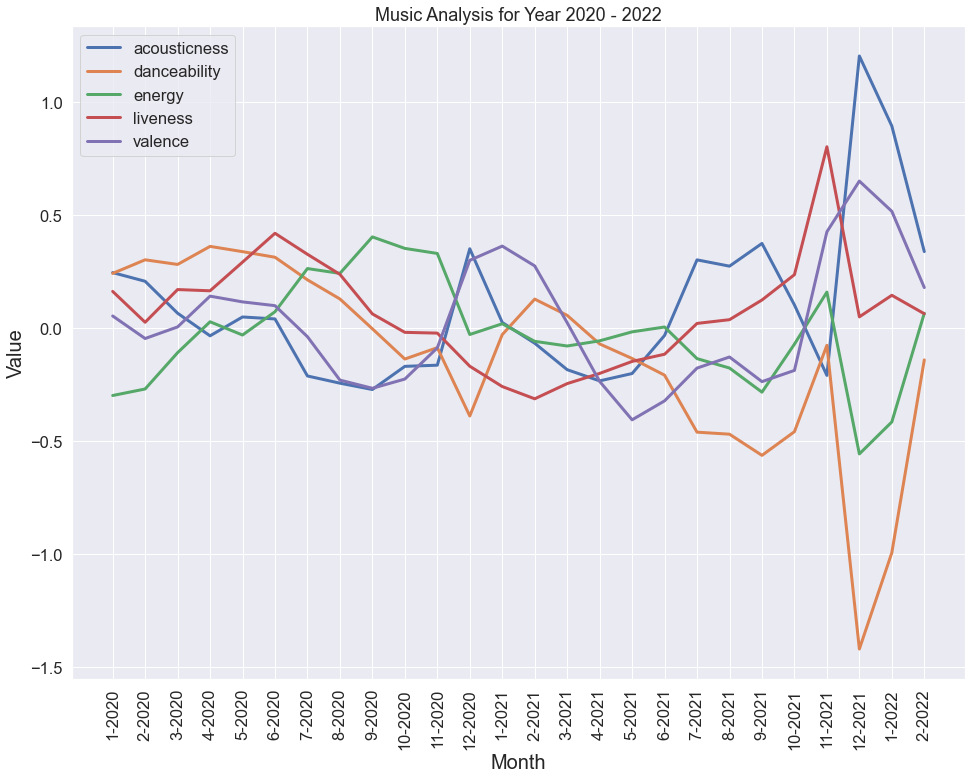

In [76]:
figure,ax = plt.subplots(figsize=(16, 12))
sns.set(font_scale=1.5)
# sns.set_style("whitegrid", {'axes.grid' : False})

columns = ["acousticness","danceability","energy", "liveness","valence"] 

 
for value in columns: 
    df = bill_s_merge[ (bill_s_merge['date_x'].dt.date >= date(2020,1,1))
          &(bill_s_merge['date_x'].dt.date <= date(2022,3,1)) ].copy()
    df[value] = (df[value] - df[value].mean()) / df[value].std()
    df['month'] = pd.DatetimeIndex(df['date_x']).month
    df['year'] = pd.DatetimeIndex(df['date_x']).year
    df['year_month'] =  df['month'].map(str) + '-' + df['year'].map(str)
    x = df.groupby(['year','month','year_month'])[value].mean()
    axes = sns.lineplot(data = x, x = 'year_month', y=x, label=value,linewidth=3)

    
axes.set_title('Music Analysis for Year 2020 - 2022')

# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))


axes.set_ylabel('Value' , fontsize=20)
axes.set_xlabel('Month' , fontsize=20)
plt.xticks(rotation = 'vertical')
plt.show()

over the pandemic years, music with high valence and liveness tend to have higher chance to show up on billboard

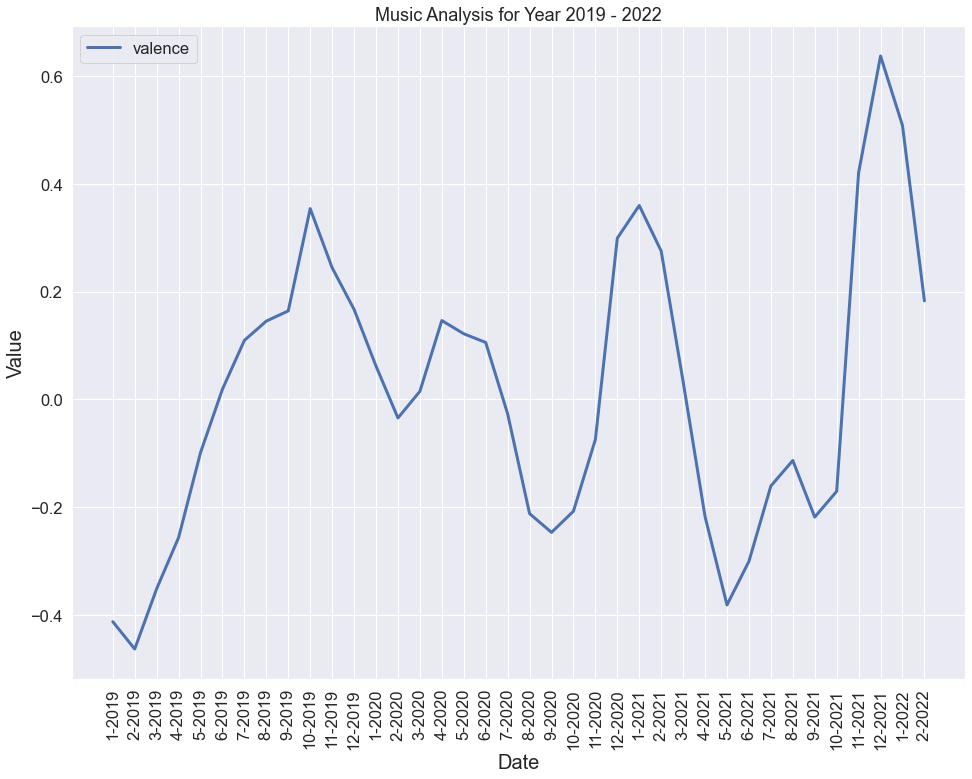

In [77]:
figure,ax = plt.subplots(figsize=(16, 12))
sns.set(font_scale=1.5)
# sns.set_style("whitegrid", {'axes.grid' : False})
columns = ["valence"] 

 
for value in columns: 
    df = bill_s_merge[ (bill_s_merge['date_x'].dt.date >= date(2019,1,1))
          &(bill_s_merge['date_x'].dt.date <= date(2022,3,1)) ].copy()
    df[value] = (df[value] - df[value].mean()) / df[value].std()
    df['month'] = pd.DatetimeIndex(df['date_x']).month
    df['year'] = pd.DatetimeIndex(df['date_x']).year
    df['year_month'] =  df['month'].map(str) + '-' + df['year'].map(str)
    x = df.groupby(['year','month','year_month'])[value].mean()
    axes = sns.lineplot(data = x, x = 'year_month', y=x, label=value,linewidth=3)

    
axes.set_title('Music Analysis for Year 2019 - 2022')

# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
# ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%Y"))

axes.set_ylabel('Value' , fontsize=20)
axes.set_xlabel('Date' , fontsize=20)
plt.xticks(rotation = 'vertical')
plt.show()

**Some** **interesting** **findings**:

2020-12: when COVID-19 first started, the energy of the billboard music decrease and inversely accoustiness of music increased

As pandemic gradually recovers, the energy of songs on billboard got enhanced. 

Durring Dec, 2021, Omicron variant starts to spread, and energy of music dives again 

# 5. Prediction 

## 5.1 billboard

In [78]:

spotify_bill_merge = pd.merge(bill_clean, spotify_clean, left_on = ['title','artist'], right_on = ['name','artists'], 
                        how='right')
spotify_bill_merge = spotify_bill_merge.drop(['title','artist'], 1)
spotify_bill_merge_new = pd.DataFrame(spotify_bill_merge[['name','artists','year',
                                            'rank',"acousticness","danceability","duration_ms","energy",
                                             "liveness",'instrumentalness',"loudness","popularity","tempo"]])
spotify_bill_merge_new['rank'] = spotify_bill_merge_new['rank'].replace(np.nan,'000')


spotify_bill_merge_new['billboardYN'] = np.where(spotify_bill_merge_new['rank'] == "000", False, True)
spotify_bill_merge_new

/tmp/ipykernel_3799890/2477179089.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  spotify_bill_merge = spotify_bill_merge.drop(['title','artist'], 1)


,name,artists,year,rank,acousticness,danceability,duration_ms,energy,liveness,instrumentalness,loudness,popularity,tempo,billboardYN
0,carve,uli,2022,000,0.674,0.645,126903,0.4450,0.1510,0.744000,-13.338,6,104.851,False
1,capítulo 216 banquero anarquista,fernando pessoa,2022,000,0.797,0.695,98200,0.2630,0.1480,0.000000,-22.136,0,102.009,False
2,vivo para quererte remasterizado,ignacio corsini,2022,000,0.994,0.434,181640,0.1770,0.2120,0.021800,-21.180,0,130.418,False
3,el prisionero remasterizado,ignacio corsini,2022,000,0.995,0.321,176907,0.0946,0.1040,0.918000,-27.961,0,169.980,False
4,lady of the evening,dick haymes,2005,000,0.989,0.402,163080,0.1580,0.3110,0.130000,-16.900,0,103.220,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
808232,云与海,阿yueyue,2020,000,0.785,0.560,258267,0.5180,0.0648,0.000000,-7.471,50,131.896,False
808233,blind,role model,2020,000,0.141,0.765,153293,0.6630,0.0924,0.000297,-5.223,72,150.091,False
808234,what theyll say about us,finneas,2020,000,0.895,0.535,187601,0.3140,0.0874,0.000150,-12.823,70,145.095,False
808235,a day at a time,gentle bones clara benin,2021,000,0.206,0.696,142003,0.6150,0.3050,0.000003,-6.212,58,90.029,False


### 5.1.1 Feature Correlation

<AxesSubplot:>

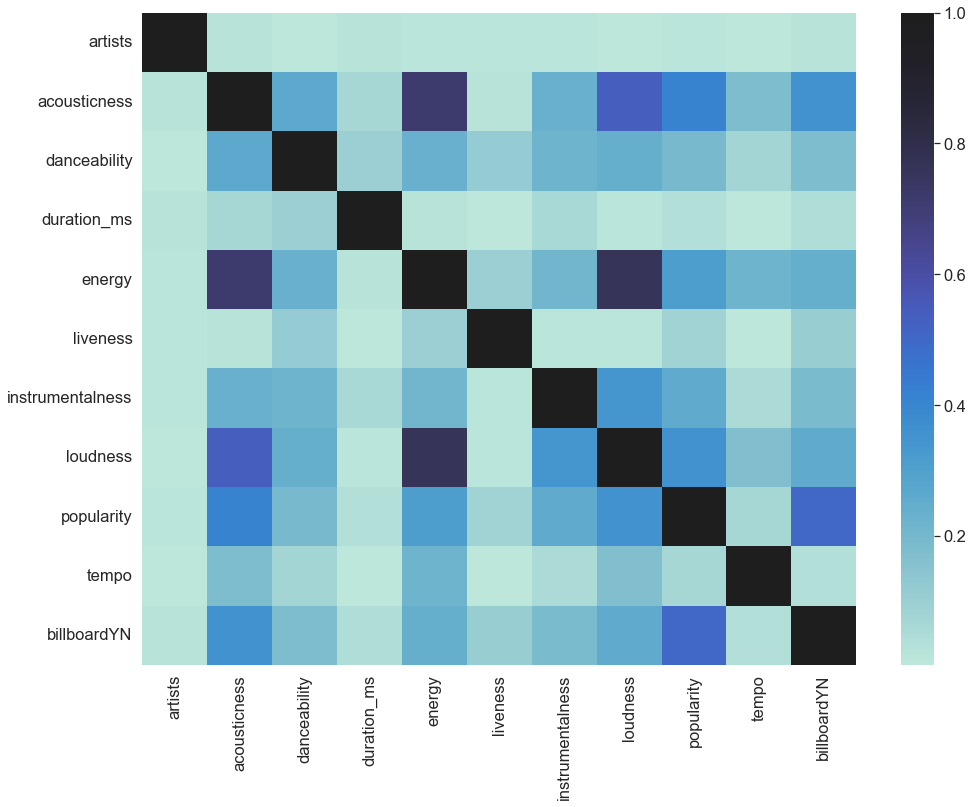

In [79]:

columns = ['artists',"acousticness","danceability","duration_ms","energy",
         "liveness",'instrumentalness',"loudness","popularity","tempo",'billboardYN'] 

spotify_bill_merge_new['artists']=spotify_bill_merge_new['artists'].astype('category').cat.codes

corr = abs(spotify_bill_merge_new[columns].corr())

plt.figure(figsize=(16,12))
sns.heatmap(corr, center = 1)

from the correlation map, whether if the music can show up on billboard seems to have postive correlation with popularity on Spotify platform and energy feature

Other interesting facts:
- The duration of a songs seems to have no corellation with the other parameters. Same with the tempo which is only weakly correlated with other features
- On the contrary, some features are heavily correlated, such as loudness and energy


Let us compute the PCA in 3 dimensions to try to relate the different features

/tmp/ipykernel_3799890/291323546.py:28: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(sct)


Text(0.5, 0.92, 'result of the pca')

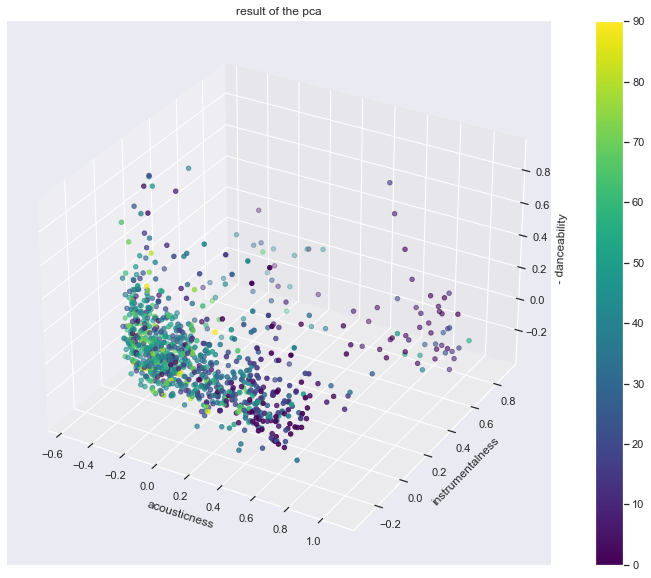

In [80]:
from mpl_toolkits.mplot3d import Axes3D

pca_columns = ["acousticness","danceability","duration_ms","energy",
         "liveness",'instrumentalness',"loudness","tempo"] 
         #popularity / billboardYN not included

pca_model = PCA(n_components=3)

normalized_s_b = spotify_bill_merge_new[pca_columns]
normalized_s_b = (normalized_s_b-normalized_s_b.min())/(normalized_s_b.max()-normalized_s_b.min())
transformed_values = pca_model.fit_transform(normalized_s_b[pca_columns])

subset = rng.choice(len(transformed_values), size=1000, replace=False)


sns.set(style= "darkgrid")
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection = '3d')

x = transformed_values[subset, 0]
y = transformed_values[subset, 1]
z = transformed_values[subset, 2]

sct = ax.scatter(x, y, z, c=spotify_bill_merge_new["popularity"][subset], cmap="viridis")
ax.set_xlabel("acousticness")
ax.set_ylabel("instrumentalness")
ax.set_zlabel("- danceability")
plt.colorbar(sct)
plt.title("result of the pca")

<AxesSubplot:>

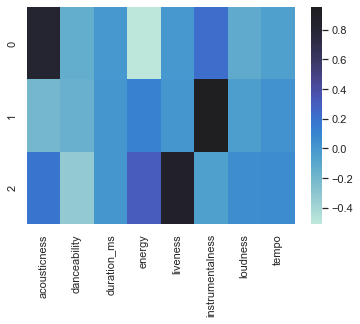

In [81]:
sns.heatmap(pca_model.components_, xticklabels=pca_columns,center = 1)


We can observe our 3 main axes
- The first (main direction) is correlated with accousticness and negative energy (and slightly correlated with instrumentalness). It shows that those two features are very opposed.
- The second is overwhelmingly correlated with instrumentalness. Thus instrumentalness is pretty orthogonal to the other coordinates.
- The third one is correlated with liveness and negative danceability


On the dimentionally-reduced data, we observe that there is a higher concentration of more energetic, less acoustic songs, and that those are more popular.
There is a small cluster of more acoustic songs that are also more instrumental and less danceable.


Now let us observe how the music distribution shifts on those coordinates

In [85]:
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython.core.display import Video


sns.set(style= "darkgrid")
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection = '3d')

ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_zlim(-1.1, 1.1)

ax.set_xlabel("acousticness")
ax.set_ylabel("instrumentalness")
ax.set_zlabel("-danceability")

ax.set_title("Evolution of US charts")

transformed_values = pd.DataFrame(transformed_values, columns=["pca_accousticness", 
                                                               "pca_instrumentalness",
                                                               "pca_liveness"])


transformed_values["year"] = spotify_bill_merge_new["year"]
transformed_values["popularity"] = spotify_bill_merge_new["popularity"]
transformed_by_year = transformed_values.groupby("year")
def animate(frame_num):
  year = 1956 + frame_num
  data = transformed_by_year.get_group(year)

  x = data["pca_accousticness"]
  y = data["pca_instrumentalness"]
  z = data["pca_liveness"]
  ax.clear()
  sct = ax.scatter(x, y, z, c=data["popularity"], cmap="viridis")
  ax.set_title(f"Evolution of US charts: {year}")
  ax.set_xlim(-1.1, 1.1)
  ax.set_ylim(-1.1, 1.1)
  ax.set_zlim(-1.1, 1.1)


  return sct

animate(0)
plt.colorbar(sct)

anim = FuncAnimation(fig, animate, frames=2020 - 1956)
video_path = output_dir / "evolution.mp4"
writervideo = FFMpegWriter(fps=8)
anim.save(video_path, writer=writervideo)
plt.close()                   # avoid plotting a spare static plot
Video(video_path)

/tmp/ipykernel_3799890/383356255.py:47: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(sct)
/tmp/ipykernel_3799890/383356255.py:47: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(sct)
/home/tris/.virtualenvs/ECE143-AmWMeq3B/lib/python3.10/site-packages/matplotlib/animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


### 5.1.2 Further Feature Analysis

In [97]:
spotify_bill_merge_new.values

array([['carve', 4079, 2022, ..., 104.851, 0, 59060],
       ['capítulo 216  banquero anarquista', 37969, 2022, ..., 102.009,
        0, 57760],
       ['vivo para quererte  remasterizado', 50988, 2022, ..., 130.418,
        0, 366007],
       ...,
       ['what theyll say about us', 38281, 2020, ..., 145.095, 0, 372959],
       ['a day at a time', 42118, 2021, ..., 90.029, 0, 12467],
       ['mar de emociones', 21411, 2015, ..., 112.204, 0, 213084]],
      dtype=object)

array([<AxesSubplot:title={'center':'popularity'}>,
       <AxesSubplot:title={'center':'energy'}>], dtype=object)

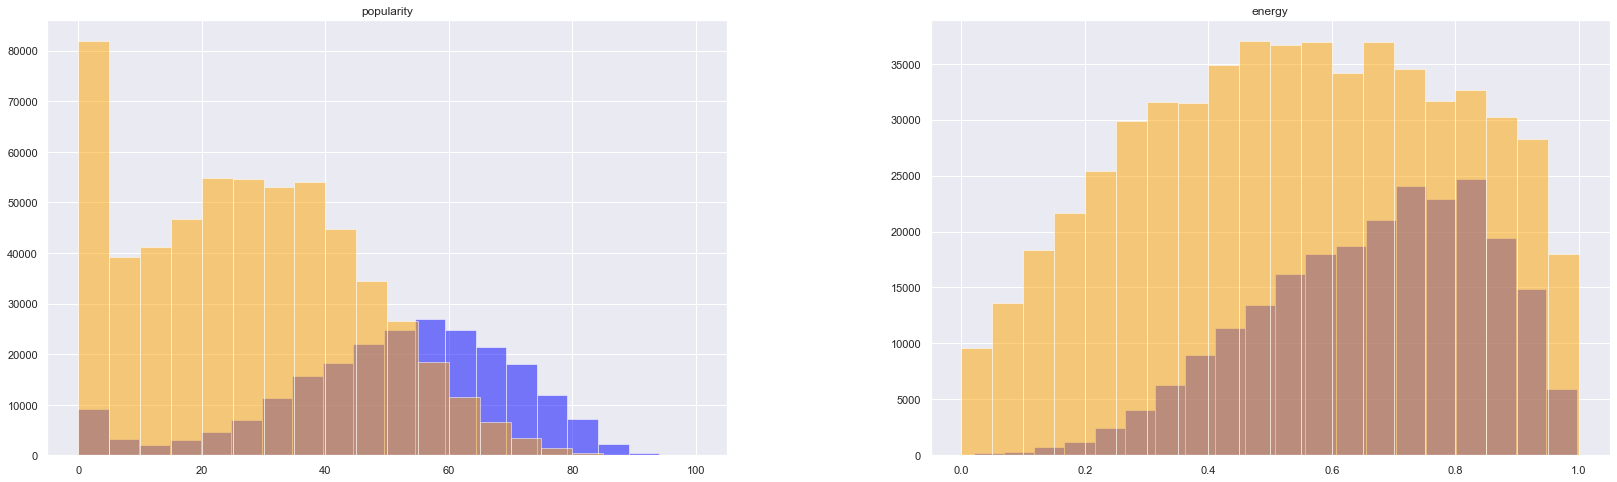

In [87]:
numerical_features = ['popularity','energy']
fig,ax = plt.subplots(1,2,figsize=(28,8))
spotify_bill_merge_new[spotify_bill_merge_new['billboardYN'] == True][numerical_features].hist(bins=20,color='blue',alpha=0.5,ax = ax,label=value)
spotify_bill_merge_new[spotify_bill_merge_new['billboardYN'] == False][numerical_features].hist(bins=20,color='orange',alpha=0.5,ax = ax)

As we can see, song's popularity in the range of 60-80 has higher rate of showing up on billboard

song's energy rate in range 0.6 - 1.9 has higher rate of showing up on biillboard


### 5.1.3 Logistic Regression Prediction   

In [88]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

In [89]:
spotify_bill_merge_new['newName']= spotify_bill_merge_new['name'].copy()
spotify_bill_merge_new

spotify_bill_merge_new['newName'] = LabelEncoder().fit_transform(spotify_bill_merge_new['newName'])
spotify_bill_merge_new

columns = ['billboardYN','rank','artists']

for column in columns :
        spotify_bill_merge_new[column] = LabelEncoder().fit_transform(spotify_bill_merge_new[column].astype(str))
        
 
            
        if is_numeric_dtype(spotify_bill_merge_new[column]):
            continue
        else :
            spotify_bill_merge_new[column] = LabelEncoder().fit_transform(spotify_bill_merge_new[column])

In [90]:
spotify_bill_merge_new['billboardYN'].value_counts()

0    573434
1    234803
Name: billboardYN, dtype: int64

/home/tris/.virtualenvs/ECE143-AmWMeq3B/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='billboardYN', ylabel='count'>

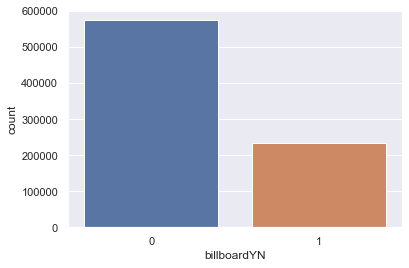

In [91]:
sns.countplot(spotify_bill_merge_new['billboardYN'])

In [92]:
spotify_bill_merge_new_1 = spotify_bill_merge_new.copy(deep=True)

spotify_bill_merge_new_1 = spotify_bill_merge_new.drop(['name','newName','year'], axis = 1)

In [100]:
accuracy=[]
feature = ['artists','acousticness','danceability','duration_ms','energy',
           'liveness','instrumentalness','loudness','popularity','tempo']
for i in range(len(feature)+1):
  X = spotify_bill_merge_new_1.drop(['billboardYN','rank'],axis=1) #Feature data set
  if i == len(feature): 
    X = X
  else:
    X = X.drop([feature[i]],axis=1) #Feature data set
  y = spotify_bill_merge_new_1['billboardYN']


  X = StandardScaler().fit_transform(X)



  logit_model=sm.Logit(y,X)
  result=logit_model.fit()


  #Split the data into 80% training and 20% testing
  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

  #Create the model
  model = LogisticRegression()
  #Train the model
  model.fit(x_train, y_train)

  #Create the predictions on the test data
  predictions = model.predict(x_test)

  #print the predictions
  # print(y_test)
  # print(predictions)



  #Check the precision, recall. f1-score
  #print(classification_report(y_test, predictions))

  from sklearn.metrics import accuracy_score
  print(accuracy_score(y_test, predictions))



Optimization terminated successfully.
         Current function value: 0.557684
         Iterations 6
0.8085407799663467
Optimization terminated successfully.
         Current function value: 0.566690
         Iterations 5
0.8002759081460952
Optimization terminated successfully.
         Current function value: 0.558210
         Iterations 6
0.8080706225873503
Optimization terminated successfully.
         Current function value: 0.557901
         Iterations 6
0.8070313273285162
Optimization terminated successfully.
         Current function value: 0.558280
         Iterations 6
0.8085160348411363
Optimization terminated successfully.
         Current function value: 0.559220
         Iterations 6
0.8079283381173908
Optimization terminated successfully.
         Current function value: 0.558318
         Iterations 6
0.80526823715728
Optimization terminated successfully.
         Current function value: 0.557848
         Iterations 6
0.8090171236266456
Optimization terminated successful

### 5.1.4 Dependency

###artists           0.00%
###acousticness     -0.82%
###danceability      -0.04%
###duration_ms      -0.15%
###energy            0.00%
###liveness          -0.06%
###instrumentalness -0.32%
###loudness          0.05%
###popularity       -7.92%
###tempo             -0.05%

#### 

## 5.2 French billboard

In [101]:
spotify_fr_bill_merge = pd.merge(fr_bill_clean, spotify_clean, left_on = ['title','artist'], right_on = ['name','artists'], 
                        how='right')
# spotify_bill_merge
# spotify_fr_bill_merge['artist']
spotify_fr_bill_merge = spotify_fr_bill_merge.drop(['title','artist'], 1)
spotify_fr_bill_merge_new = pd.DataFrame(spotify_fr_bill_merge[['name','artists','year',
                                            'position',"acousticness","danceability","duration_ms","energy",
                                             "liveness",'instrumentalness',"loudness","popularity","tempo"]])
spotify_fr_bill_merge_new['position'] = spotify_fr_bill_merge_new['position'].replace(np.nan,'000')


spotify_fr_bill_merge_new['billboardYN'] = np.where(spotify_fr_bill_merge_new['position'] == "000", False, True)
spotify_fr_bill_merge_new
# fr_bill_clean

/tmp/ipykernel_3799890/222593873.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  spotify_fr_bill_merge = spotify_fr_bill_merge.drop(['title','artist'], 1)


,name,artists,year,position,acousticness,danceability,duration_ms,energy,liveness,instrumentalness,loudness,popularity,tempo,billboardYN
0,carve,uli,2022,000,0.674,0.645,126903,0.4450,0.1510,0.744000,-13.338,6,104.851,False
1,capítulo 216 banquero anarquista,fernando pessoa,2022,000,0.797,0.695,98200,0.2630,0.1480,0.000000,-22.136,0,102.009,False
2,vivo para quererte remasterizado,ignacio corsini,2022,000,0.994,0.434,181640,0.1770,0.2120,0.021800,-21.180,0,130.418,False
3,el prisionero remasterizado,ignacio corsini,2022,000,0.995,0.321,176907,0.0946,0.1040,0.918000,-27.961,0,169.980,False
4,lady of the evening,dick haymes,2005,000,0.989,0.402,163080,0.1580,0.3110,0.130000,-16.900,0,103.220,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
657806,云与海,阿yueyue,2020,000,0.785,0.560,258267,0.5180,0.0648,0.000000,-7.471,50,131.896,False
657807,blind,role model,2020,000,0.141,0.765,153293,0.6630,0.0924,0.000297,-5.223,72,150.091,False
657808,what theyll say about us,finneas,2020,000,0.895,0.535,187601,0.3140,0.0874,0.000150,-12.823,70,145.095,False
657809,a day at a time,gentle bones clara benin,2021,000,0.206,0.696,142003,0.6150,0.3050,0.000003,-6.212,58,90.029,False


### 5.2.1 Feature Correlation

<AxesSubplot:>

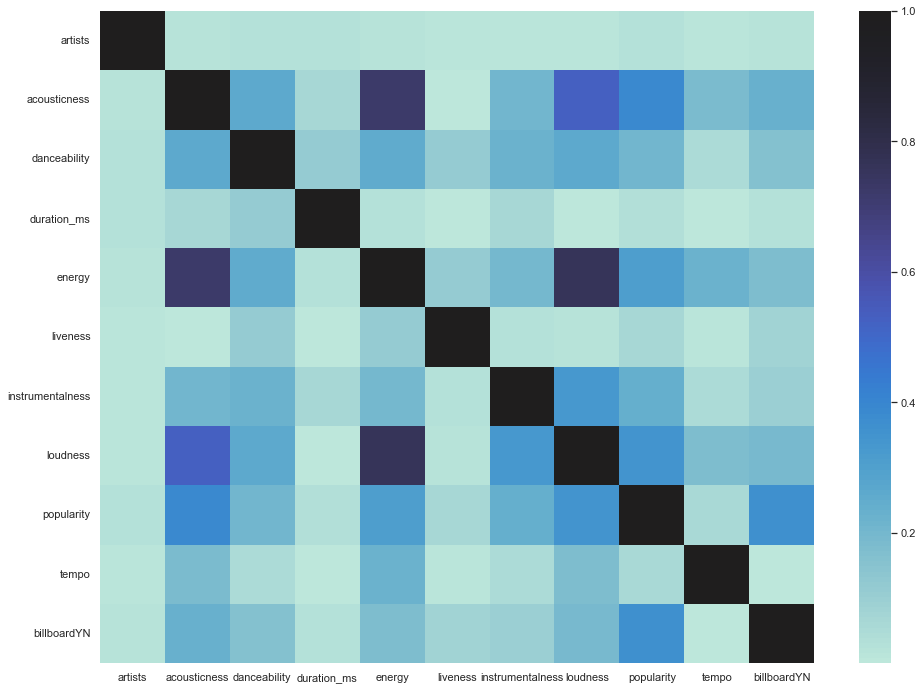

In [102]:
columns = ['artists',"acousticness","danceability","duration_ms","energy",
         "liveness",'instrumentalness',"loudness","popularity","tempo",'billboardYN'] 

spotify_fr_bill_merge_new['artists']=spotify_fr_bill_merge_new['artists'].astype('category').cat.codes

corr = abs(spotify_fr_bill_merge_new[columns].corr())

plt.figure(figsize=(16,12))
sns.heatmap(corr, center = 1)

### 5.2.2 Further Feature Analysis

### 5.2.3 LR-Prediction

In [103]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

In [104]:
spotify_fr_bill_merge_new['newName']= spotify_fr_bill_merge_new['name'].copy()
spotify_fr_bill_merge_new

spotify_fr_bill_merge_new['newName'] = LabelEncoder().fit_transform(spotify_fr_bill_merge_new['newName'])
spotify_fr_bill_merge_new

columns = ['billboardYN','position','artists']

for column in columns :
        spotify_fr_bill_merge_new[column] = LabelEncoder().fit_transform(spotify_fr_bill_merge_new[column].astype(str))
        
 
            
        if is_numeric_dtype(spotify_fr_bill_merge_new[column]):
            continue
        else :
            spotify_fr_bill_merge_new[column] = LabelEncoder().fit_transform(spotify_fr_bill_merge_new[column])

In [105]:
spotify_fr_bill_merge_new['billboardYN'].value_counts()

0    581080
1     76731
Name: billboardYN, dtype: int64

/home/tris/.virtualenvs/ECE143-AmWMeq3B/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='billboardYN', ylabel='count'>

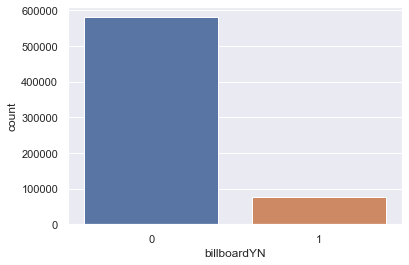

In [106]:
sns.countplot(spotify_fr_bill_merge_new['billboardYN'])

In [107]:
spotify_fr_bill_merge_new_1 = spotify_fr_bill_merge_new.copy(deep=True)

spotify_fr_bill_merge_new_1 = spotify_fr_bill_merge_new.drop(['name','newName','year'], axis = 1)

In [108]:
spotify_fr_bill_merge_new_1

,artists,position,acousticness,danceability,duration_ms,energy,liveness,instrumentalness,loudness,popularity,tempo,billboardYN
0,4079,0,0.674,0.645,126903,0.4450,0.1510,0.744000,-13.338,6,104.851,0
1,37969,0,0.797,0.695,98200,0.2630,0.1480,0.000000,-22.136,0,102.009,0
2,50988,0,0.994,0.434,181640,0.1770,0.2120,0.021800,-21.180,0,130.418,0
3,50988,0,0.995,0.321,176907,0.0946,0.1040,0.918000,-27.961,0,169.980,0
4,28971,0,0.989,0.402,163080,0.1580,0.3110,0.130000,-16.900,0,103.220,0
...,...,...,...,...,...,...,...,...,...,...,...,...
657806,15045,0,0.785,0.560,258267,0.5180,0.0648,0.000000,-7.471,50,131.896,0
657807,97872,0,0.141,0.765,153293,0.6630,0.0924,0.000297,-5.223,72,150.091,0
657808,38281,0,0.895,0.535,187601,0.3140,0.0874,0.000150,-12.823,70,145.095,0
657809,42118,0,0.206,0.696,142003,0.6150,0.3050,0.000003,-6.212,58,90.029,0


In [109]:
accuracy=[]
feature = ['artists','acousticness','danceability','duration_ms','energy',
           'liveness','instrumentalness','loudness','popularity','tempo']
for i in range(len(feature)+1):
  X = spotify_fr_bill_merge_new_1.drop(['billboardYN','position'],axis=1) #Feature data set
  if i == len(feature): 
    X = X
  else:
    X = X.drop([feature[i]],axis=1) #Feature data set
  y = spotify_fr_bill_merge_new_1['billboardYN']


  X = StandardScaler().fit_transform(X)



  import statsmodels.api as sm
  logit_model=sm.Logit(y,X)
  result=logit_model.fit()


  #Split the data into 80% training and 20% testing
  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

  #Create the model
  model = LogisticRegression()
  #Train the model
  model.fit(x_train, y_train)

  #Create the predictions on the test data
  predictions = model.predict(x_test)

  #print the predictions
  # print(y_test)
  # print(predictions)



  #Check the precision, recall. f1-score
  #print(classification_report(y_test, predictions))

  from sklearn.metrics import accuracy_score
  print(accuracy_score(y_test, predictions))



Optimization terminated successfully.
         Current function value: 0.660971
         Iterations 4
0.891398037442138
Optimization terminated successfully.
         Current function value: 0.661645
         Iterations 4
0.8917020742914041
Optimization terminated successfully.
         Current function value: 0.661564
         Iterations 4
0.8922113360139249
Optimization terminated successfully.
         Current function value: 0.660960
         Iterations 4
0.8911928125688834
Optimization terminated successfully.
         Current function value: 0.660938
         Iterations 4
0.8915272531030761
Optimization terminated successfully.
         Current function value: 0.661362
         Iterations 4
0.8913372300722847
Optimization terminated successfully.
         Current function value: 0.660939
         Iterations 4
0.8918768954797321
Optimization terminated successfully.
         Current function value: 0.661136
         Iterations 4
0.8918996982434271
Optimization terminated successfu

### 5.2.4 Dependency

###artists          -0.01%
###acousticness      0.02%
###danceability      0.07%
###duration_ms      -0.03%
###energy            0.00%
###liveness         -0.02%
###instrumentalness  0.04%
###loudness          0.04%
###popularity       -0.77%
###tempo            -0.05%

## 5.3 UK billboard

In [110]:
spotify_uk_bill_merge = pd.merge(uk_bill_clean, spotify_clean, left_on = ['title','artist'], right_on = ['name','artists'], 
                        how='right')
# spotify_uk_bill_merge
# # spotify_fr_bill_merge['artist']
spotify_uk_bill_merge = spotify_uk_bill_merge.drop(['title','artist'], 1)
spotify_uk_bill_merge_new = pd.DataFrame(spotify_uk_bill_merge[['name','artists','year',
                                            'position',"acousticness","danceability","duration_ms","energy",
                                             "liveness",'instrumentalness',"loudness","popularity","tempo"]])
spotify_uk_bill_merge_new['position'] = spotify_uk_bill_merge_new['position'].replace(np.nan,'000')


spotify_uk_bill_merge_new['billboardYN'] = np.where(spotify_uk_bill_merge_new['position'] == "000", False, True)
spotify_uk_bill_merge_new
# # fr_bill_clean

/tmp/ipykernel_3799890/53543916.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  spotify_uk_bill_merge = spotify_uk_bill_merge.drop(['title','artist'], 1)


,name,artists,year,position,acousticness,danceability,duration_ms,energy,liveness,instrumentalness,loudness,popularity,tempo,billboardYN
0,carve,uli,2022,000,0.674,0.645,126903,0.4450,0.1510,0.744000,-13.338,6,104.851,False
1,capítulo 216 banquero anarquista,fernando pessoa,2022,000,0.797,0.695,98200,0.2630,0.1480,0.000000,-22.136,0,102.009,False
2,vivo para quererte remasterizado,ignacio corsini,2022,000,0.994,0.434,181640,0.1770,0.2120,0.021800,-21.180,0,130.418,False
3,el prisionero remasterizado,ignacio corsini,2022,000,0.995,0.321,176907,0.0946,0.1040,0.918000,-27.961,0,169.980,False
4,lady of the evening,dick haymes,2005,000,0.989,0.402,163080,0.1580,0.3110,0.130000,-16.900,0,103.220,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
784960,云与海,阿yueyue,2020,000,0.785,0.560,258267,0.5180,0.0648,0.000000,-7.471,50,131.896,False
784961,blind,role model,2020,000,0.141,0.765,153293,0.6630,0.0924,0.000297,-5.223,72,150.091,False
784962,what theyll say about us,finneas,2020,000,0.895,0.535,187601,0.3140,0.0874,0.000150,-12.823,70,145.095,False
784963,a day at a time,gentle bones clara benin,2021,000,0.206,0.696,142003,0.6150,0.3050,0.000003,-6.212,58,90.029,False


### 5.3.1 Feature Correlation

<AxesSubplot:>

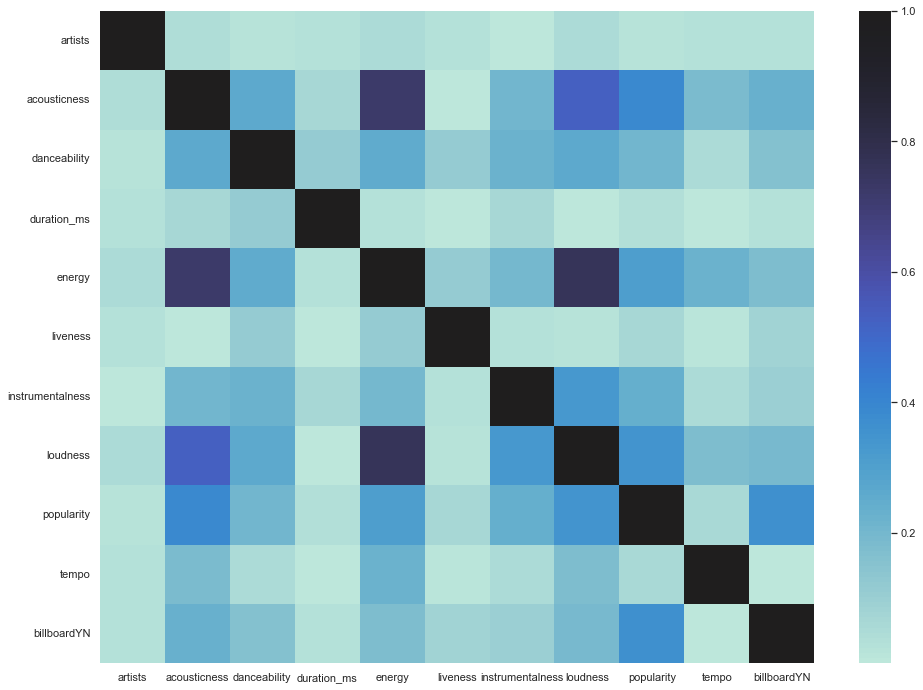

In [111]:
columns = ['artists',"acousticness","danceability","duration_ms","energy",
         "liveness",'instrumentalness',"loudness","popularity","tempo",'billboardYN'] 

spotify_uk_bill_merge_new['artists']=spotify_uk_bill_merge_new['artists'].astype('category').cat.codes

corr = abs(spotify_fr_bill_merge_new[columns].corr())

plt.figure(figsize=(16,12))
sns.heatmap(corr, center = 1)

### 5.3.2 Further Feature Analysis

### 5.3.3 LR-Prediction

In [112]:
spotify_uk_bill_merge_new['newName']= spotify_uk_bill_merge_new['name'].copy()
spotify_uk_bill_merge_new

spotify_uk_bill_merge_new['newName'] = LabelEncoder().fit_transform(spotify_uk_bill_merge_new['newName'])
spotify_uk_bill_merge_new

columns = ['billboardYN','position','artists']

for column in columns :
        spotify_uk_bill_merge_new[column] = LabelEncoder().fit_transform(spotify_uk_bill_merge_new[column].astype(str))
        
 
            
        if is_numeric_dtype(spotify_uk_bill_merge_new[column]):
            continue
        else :
            spotify_uk_bill_merge_new[column] = LabelEncoder().fit_transform(spotify_uk_bill_merge_new[column])

In [113]:
spotify_uk_bill_merge_new['billboardYN'].value_counts()

0    568335
1    216630
Name: billboardYN, dtype: int64

/home/tris/.virtualenvs/ECE143-AmWMeq3B/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='billboardYN', ylabel='count'>

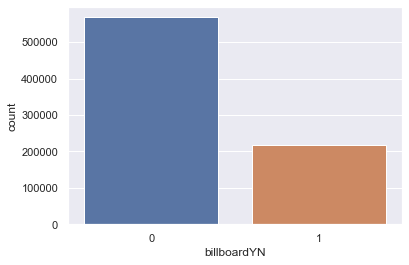

In [114]:
sns.countplot(spotify_uk_bill_merge_new['billboardYN'])

In [115]:
spotify_uk_bill_merge_new_1 = spotify_uk_bill_merge_new.copy(deep=True)

spotify_uk_bill_merge_new_1 = spotify_uk_bill_merge_new.drop(['name','newName','year'], axis = 1)

In [116]:
accuracy=[]
feature = ['artists','acousticness','danceability','duration_ms','energy',
           'liveness','instrumentalness','loudness','popularity','tempo']
for i in range(len(feature)+1):
  X = spotify_uk_bill_merge_new_1.drop(['billboardYN','position'],axis=1) #Feature data set
  if i == len(feature): 
    X = X
  else:
    X = X.drop([feature[i]],axis=1) #Feature data set
  y = spotify_uk_bill_merge_new_1['billboardYN']


  X = StandardScaler().fit_transform(X)



  import statsmodels.api as sm
  logit_model=sm.Logit(y,X)
  result=logit_model.fit()


  #Split the data into 80% training and 20% testing
  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

  #Create the model
  model = LogisticRegression()
  #Train the model
  model.fit(x_train, y_train)

  #Create the predictions on the test data
  predictions = model.predict(x_test)

  #print the predictions
  # print(y_test)
  # print(predictions)



  #Check the precision, recall. f1-score
  #print(classification_report(y_test, predictions))

  from sklearn.metrics import accuracy_score
  print(accuracy_score(y_test, predictions))



Optimization terminated successfully.
         Current function value: 0.598128
         Iterations 5
0.7861178523883231
Optimization terminated successfully.
         Current function value: 0.603162
         Iterations 5
0.7836018166415063
Optimization terminated successfully.
         Current function value: 0.598114
         Iterations 5
0.7855700572636997
Optimization terminated successfully.
         Current function value: 0.598182
         Iterations 5
0.7865955806946806
Optimization terminated successfully.
         Current function value: 0.598182
         Iterations 5
0.7860223067270515
Optimization terminated successfully.
         Current function value: 0.598931
         Iterations 5
0.78592676106578
Optimization terminated successfully.
         Current function value: 0.598422
         Iterations 5
0.7854554024701739
Optimization terminated successfully.
         Current function value: 0.598646
         Iterations 5
0.787831304580459
Optimization terminated successfull

### 5.3.4 Dependency

###artists          -0.01%
###acousticness      -0.26%
###danceability      -0.06%
###duration_ms      0.04%
###energy            -0.02%
###liveness         -0.03%
###instrumentalness  -0.07%
###loudness          0.16%
###popularity       -5.29%
###tempo            0.03%

# cross-country analysis

### 1. Load UK and French billboards

In [69]:
uk_charts = pd.read_csv(data_dir / 'UK_charts.csv', index_col=0,
                          dtype={"last-week":"category", "title":"string", 
                                 "artist":"string", "label-cat":"string",},
                        parse_dates=True)
uk_charts.date = pd.to_datetime(uk_charts.date)
uk_charts = clean(uk_charts, ["title", "artist", "label-cat"])
uk_charts = uk_charts.drop_duplicates()
uk_charts

,position,last-week,title,artist,label-cat,peak position,weeks of charts,year,week,date
0,1,New,here in my heart,al martino,capitol,1,1,1952,46,1952-11-14
3,2,New,you belong to me,jo stafford,columbia,2,1,1952,46,1952-11-14
4,3,New,somewhere along the way,nat king cole,capitol,3,1,1952,46,1952-11-14
5,4,New,the isle of innisfree,bing crosby,brunswick,4,1,1952,46,1952-11-14
6,5,New,feet up pat him on the popo,guy mitchell,columbia,5,1,1952,46,1952-11-14
...,...,...,...,...,...,...,...,...,...,...
274044,96,Re,little things,abba,polar,61,3,2021,52,2021-12-31
274045,97,Re,i want to come home for christmas,summer walker,interscope,94,2,2021,52,2021-12-31
274046,98,New,jingle bell rock,alessia cara,virgin,98,1,2021,52,2021-12-31
274047,99,New,kiss me its christmas,leona lewis ft neyo,sony music cg,99,1,2021,52,2021-12-31


In [70]:
fr_charts = pd.read_csv(data_dir / 'french_charts.csv', index_col=0,
                        dtype= {"evol":"category", "artist":"string", "title":"string"})
fr_charts = fr_charts.drop_duplicates().dropna()
fr_charts = clean(fr_charts, ["title", "artist"])
fr_charts

,position,evol,artist,title,year,week
0,1,=,peter et sloane,besoin de rien envie de toi,1984,47
1,2,=,stevie wonder,i just called to say i love you,1984,47
2,3,+1,cookie dingler,femme liberee,1984,47
3,4,Entrée,frederic francois,mon coeur te dit je taime,1984,47
4,5,=,ray parker jr,ghostbusters,1984,47
...,...,...,...,...,...,...
93045,46,-3,the weeknd,in your eyes,2020,51
93046,47,+13,johnny hallyday,deux sortes dhommes nashville blues live,2020,51
93047,48,Entrée,andy muschietti,ca,2020,51
93048,49,-48,mylene farmer,lame dans leau,2020,51


In [71]:
us_charts = bill.copy()
#us_charts.date.astype("date")
us_charts["date"] = pd.to_datetime(us_charts["date"])
us_charts = pd.concat([us_charts,  us_charts.date.dt.isocalendar()[["year", "week"]]], axis=1)
us_charts

,date,weeks,title,artist,rank,peakpos,lastpos,isnew,year,week
0,2022-02-18,7,we dont talk about bruno,carolina gaitan mauro castillo adassa rhenzy f...,1,1,1,False,2022,7
1,2022-02-18,1,do we have a problem,nicki minaj x lil baby,2,2,0,True,2022,7
2,2022-02-18,18,easy on me,adele,3,1,2,False,2022,7
3,2022-02-18,56,heat waves,glass animals,4,3,3,False,2022,7
4,2022-02-18,31,stay,the kid laroi justin bieber,5,1,4,False,2022,7
...,...,...,...,...,...,...,...,...,...,...
234694,1977-03-04,2,theme from rocky gonna fly now,rhythm heritage,95,96,98,False,1977,9
234695,1977-03-04,1,try it on,exile,96,97,0,True,1977,9
234696,1977-03-04,9,fancy dancer,commodores,97,39,56,False,1977,9
234697,1977-03-04,1,it aint easy comin down,charlene,98,99,0,True,1977,9


The french charts have a smaller timespan (from 1984-11-23 to 2020-12-18) and 50 ranks. Let us limit ourselves to that timespan, and those ranks.

In [72]:
uk_charts = uk_charts[(uk_charts.date >= datetime(1984,11,23)) & (uk_charts.date <= datetime(2020,12,18)) & (uk_charts.position <= 50)]
us_charts = us_charts[(us_charts.date >= datetime(1984,11,23)) & (us_charts.date <= datetime(2020,12,18)) & (us_charts["rank"] <= 50)]

### Songs in common

How many songs are common to the three charts?
To each pair of the charts?

Text(0.5, 1.0, 'Songs in common in the datasets')

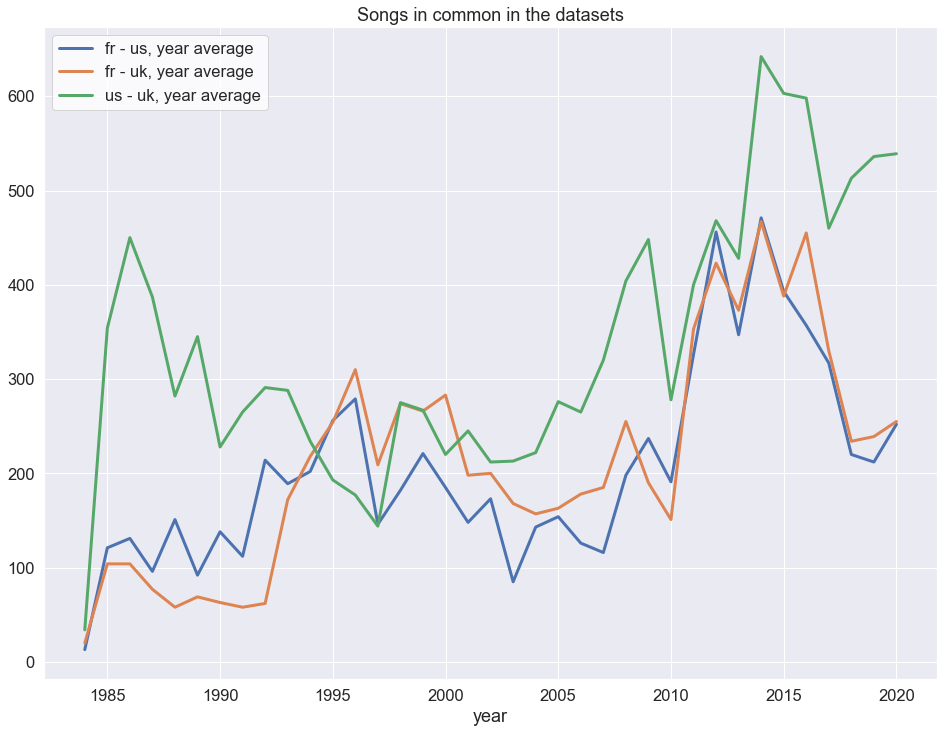

In [73]:
charts = {"fr": fr_charts, "us": us_charts, "uk": uk_charts}
figure,ax = plt.subplots(figsize=(16,12))


sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'axes.grid' : False})

for (c1, charts1), (c2, charts2) in it.combinations(charts.items(), 2):
  common = charts1.merge(charts2, left_on = ["title", "artist", "week", "year"], right_on = ["title", "artist", "week", "year"], how="inner")
  #dates = pd.to_datetime(common.year.astype(str), format='%Y') + \
  #           pd.to_timedelta(common.week.mul(7).astype(str) + ' days')
  #common["date"] = dates
  #vals = common.groupby("date").size().rolling(30).mean()
  vals = common.groupby("year").size()
  sns.lineplot(data=vals, label=f"{c1} - {c2}, year average", linewidth = 3)
  
plt.title("Songs in common in the datasets")

As expected this is pretty noisy, but we do observe 
- that the curves are pretty correlated after 1995, proof that this is influenced by international hits that make the charts in the 3 countries
- That the `UK - US` curve is above the other two, confirming the theory of a "language barrier": Songs are shared more easily between countries that share the same language
- That the `FR - US` and `FR - UK` lines look very similar, suggesting hits that break the language barrier are international hits common to the 3 countries

### LDA

Now let us observe what characterestics differentiate the two. For that let us compute the Linear discriminants between the different charts


First let us add the million song dataset data, to get quantified analysis on the songs.


In [74]:
fr_charts = pd.merge(fr_charts, million_song_clean, left_on = ['title','artist'], right_on = ['title','artist_name'], 
                        suffixes = ("", "_ms"), how='inner')
fr_charts = pd.merge(fr_charts, spotify_clean, left_on = ['title','artist'], right_on = ['name','artists'], 
                        suffixes = ("", "_s"), how='inner')

uk_charts = pd.merge(uk_charts, million_song_clean, left_on = ['title','artist'], right_on = ['title','artist_name'], 
                        suffixes = ("", "_ms"), how='inner')
uk_charts = pd.merge(uk_charts, spotify_clean, left_on = ['title','artist'], right_on = ['name','artists'], 
                        suffixes = ("", "_s"), how='inner')

us_charts = pd.merge(us_charts, million_song_clean, left_on = ['title','artist'], right_on = ['title','artist_name'], 
                        suffixes = ("", "_ms"), how='inner')
us_charts = pd.merge(us_charts, spotify_clean, left_on = ['title','artist'], right_on = ['name','artists'], 
                        suffixes = ("", "_s"), how='inner')

In [75]:
lda_columns = ["acousticness", "danceability_s", "duration","energy_s", "key", "mode",
               "time_signature", "liveness",'instrumentalness',"loudness","tempo"] 

lda_names = [cname.replace("_s","") for cname in lda_columns]

charts = {"France": fr_charts, "US": us_charts, "UK": uk_charts}

#first, normalize:
for c in charts.values():
  c[lda_columns] = (c[lda_columns] - c[lda_columns].min())/ (c[lda_columns].max() - c[lda_columns].min())
  #print(c[lda_columns].head())

discriminants = np.zeros((3, len(lda_columns)))
names = []
for i, ((c1, charts1), (c2, charts2)) in enumerate(it.combinations(charts.items(), 2)):
  lda_model = LDA(priors=[.5,.5], shrinkage="auto", solver="lsqr")
  features1 = charts1[lda_columns].copy()
  features1["is2"] = False
  features2 = charts2[lda_columns].copy()
  features2["is2"] = True

  total = pd.concat([features1, features2]) 
  lda_model.fit(total[lda_columns], total["is2"])
  discriminants[i, :] = lda_model.coef_

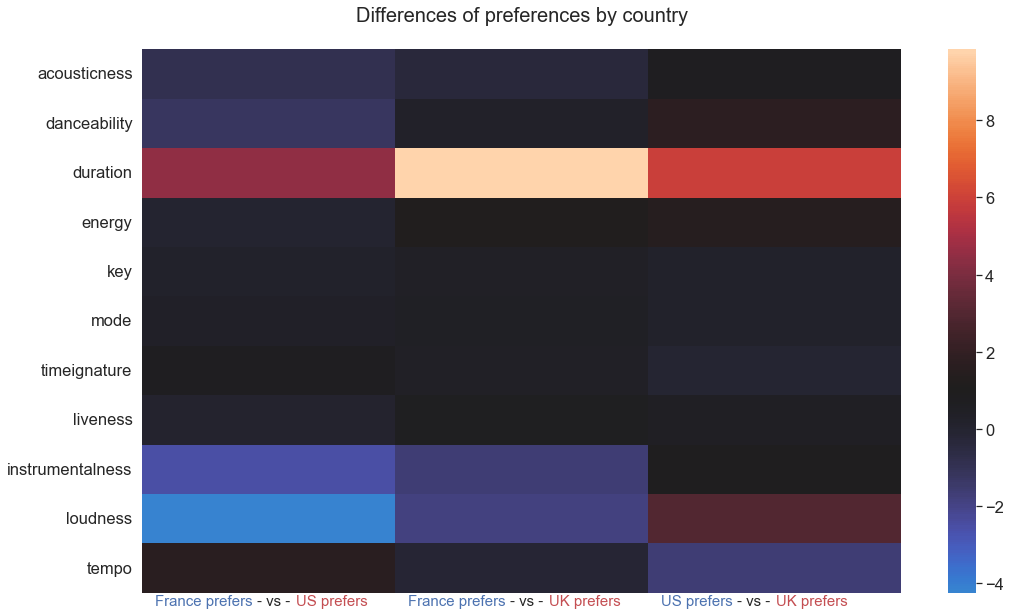

In [81]:
from matplotlib.offsetbox import TextArea, HPacker, AnchoredOffsetbox
_, ax = plt.subplots(figsize=(17, 10))
sns.color_palette("vlag", as_cmap=True)
hm = sns.heatmap(discriminants.transpose(), yticklabels=lda_names, center = 1, ax=ax)
for label, (c1, c2) in zip(hm.get_xticklabels(), it.combinations(charts, 2)):
  x, y = label.get_position()
  label.set(visible=False)
  name0 = TextArea(f"{c1} prefers", textprops=dict(color="b", fontsize=15))
  namevs = TextArea(f"- vs -", textprops=dict(fontsize=15))
  name1 = TextArea(f"{c2} prefers", textprops=dict(color="r", fontsize=15))
  namebox = HPacker(children=[name0, namevs, name1], align="center", pad=0., sep=5.)

  anchored_box = AnchoredOffsetbox(loc=3, child=namebox, pad=0., frameon=False, bbox_to_anchor=(x - .45, y - .01), 
                                  bbox_transform=label._transform, borderpad=0.
                                   )
  ax.add_artist(anchored_box)
  #print(vars(i))

plt.title("Differences of preferences by country\n", fontsize=20);


**How to read:** 
- Features in black are mostly indifferent
- Features in blue/white are preffered by the first country
- Features in red/orange are preffered by the second country

--- 
**Analysis:**
- France, compared to the US, prefers shorter, louder and more instrumental songs.
- Uk, compared to France, prefers shorter and quieter songs
- The US, compared to the UK, prefers longer and quieter songs, but with more energy. the Uk slightly prefers more instrumental songs.

In [77]:
from utils.display import table_comparison

In [78]:
from IPython.display import HTML, display
lda_columns = np.array(lda_columns)
threshold = 1.5

for (c0, c1), disc in  zip(it.combinations(charts, 2), discriminants):
    features0 = lda_columns[disc <= - threshold]
    features1 = lda_columns[disc >=   threshold]
    #print(features0, features1)
    display(table_comparison(f"Preferences of {c0} vs preferences of {c1}", 
                             c0, c1, features0, features1))
  